# Beat The Bookies: Predicting EPL Matches
_Team C_

__Mohammad Ali Syed, Abdul Al-Fahim, Dylan Hoi, Henry Chen, Chris Wong & Yolanne Lee__

**Contents:**

- [Section 1](#section1): Introduction

- [Section 2](#section2): Data Import

- [Section 3](#section3): Data Transformation & Exploration
>- [Section 3.1](#section31): Initial Data Exploration
>>- [Section 3.1.2](#section312): Relationship Between Attributes
>>- [Section 3.1.3](#section313): Initial Data Preprocessing
>>- [Section 3.1.4](#section314): Training model on entire featureset
>>- [Section 3.1.5](#section315): Random Forest Tree for entire featureset
>>- [Section 3.1.6](#section316): Training model without Referee
>>- [Section 3.1.7](#section317): Random Forest Tree without Referee
>>- [Section 3.1.8](#section318): Training model without Date
>>- [Section 3.1.9](#section319): Random Forest Tree without Date
>>- [Section 3.1.10](#section3110): Training model on only in-game stats
>>- [Section 3.1.11](#section3111): Visualising selected features
>- [Section 3.2](#section32): Priors Feature Construction
>>- [Section 3.2.1](#section321): Data Cleaning
>>- [Section 3.2.2](#section322): Cumulative Full-time W/L Ratio
>>- [Section 3.2.3](#section323): Cumulative Half-time W/L Ratio
>>- [Section 3.2.4](#section324): Cumulative Full-Time goals scored
>>- [Section 3.2.5](#section325): Cumulative Half-time W/L Ratio
>>- [Section 3.2.6](#section326): Previous shots on target
>>- [Section 3.2.7](#section327): Computing previous fouls
>>- [Section 3.2.8](#section328): Computing previous corners
>>- [Section 3.2.9](#section329): Computing previous goals before half-time
>>- [Section 3.2.10](#section3210): Compute previous goals after half-time
>>- [Section 3.2.11](#section3211): Computing previous goals conceded before half-time
>>- [Section 3.2.12](#section3212): Computing previous goals conceded after half-time
>>- [Section 3.2.13](#section3213): Matches Played
>- [Section 3.3](#section33): Additional Features
>>- [Section 3.3.1](#section331): Distance Travelled for Away Teams
>>- [Section 3.3.2](#section332): Average shots on goal in the past 3 matches
>>- [Section 3.3.3](#section333): WL Performance of past 3 matches
>>- [Section 3.3.4](#section334): Cumulative Full Time Goal Difference
>>- [Section 3.3.5](#section335): Goalkeeper Stats
>- [Section 3.4](#section34): Derive Priors
>- [Section 3.5](#section35): Final Data Preprocessing
>>- [Section 3.5.1](#section351): Split Data
>- [Section 3.6](#section36): Scale Data


- [Section 4](#section4): Methodology Overview

- [Section 5](#section5): Model Training & Validation
>- [Section 5.1](#section51): Base Models
>>- [Section 5.1.1](#section511): Gaussian Naive Bayes
>>- [Section 5.1.2](#section512): Generic SVM
>>- [Section 5.1.3](#section513): Logistic Regression
>- [Section 5.2](#section52): Boosting Models
>>- [Section 5.2.1](#section521): XGBoost
>>- [Section 5.2.2](#section522): AdaBoost
>>- [Section 5.2.3](#section523): GradientBoost
>>- [Section 5.2.4](#section524): LightGBM
>- [Section 5.3](#section53): Neural Network Models
>>- [Section 5.3.1](#section531): Standard Neural Network
>>- [Section 5.3.2](#section532): Vanilla Neural Network
>>- [Section 5.3.3](#section533): Deep Neural Network
>>- [Section 5.3.4](#section534): Recurrent Neural Network
>>- [Section 5.3.5](#section535): Gated Recurrent Neural Network
>>- [Section 5.3.6](#section536): Long Short-Term Memory Neural Network
>>- [Section 5.3.7](#section537): Convolutional Neural Network
>- [Section 5.4](#section54): Time Series Models
>>- [Section 5.4.1](#section541): Prophet
>>- [Section 5.4.2](#section542): Arima

- [Section 6](#section6): Results

- [Section 7](#section7): Final Predictions on Test Set

## 1. Introduction

## 2. Data Import
<a name='section2'></a>

In [1]:
#Import packages
import math
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
from collections import Counter, deque

#!pip install geopy
#!pip install sklearn

#For Computing Priors
from geopy.distance import geodesic 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report,confusion_matrix, accuracy_score


#For Visualisation
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

#For Model Selection
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [2]:
# Import Data

# EPL Training Data
dirName = 'Data_Files/'
filePath = dirName + 'epl-training.csv'
data = pd.read_csv(filePath)

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2000-2008.
# Reformatted to suit our current data architecture, additional 3,047 rows x 22 columns
filePath = dirName + 'epl-training-extra.csv'
extraData = pd.read_csv(filePath)
#data = data.append(extraData, ignore_index = True) #append additional data

# Additional EPL Stadium Location Data
filePath = dirName + 'epl-stadium.csv'
locationData = pd.read_csv(filePath)

# Additional EPL Goalkeeper Data
filePath = dirName + 'epl-goalkeeping.csv'
GKData = pd.read_csv(filePath)

#Remove empty nan columns at the end
data = data.iloc[:, 0:22]
pd.set_option('display.max_columns', None)
data.head()

Date       HomeTeam   AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  16/08/2008        Arsenal  West Brom     1     0   H     1     0   H   
1  16/08/2008         Bolton      Stoke     3     1   H     3     0   H   
2  16/08/2008        Everton  Blackburn     2     3   A     1     1   D   
3  16/08/2008           Hull     Fulham     2     1   H     1     1   D   
4  16/08/2008  Middlesbrough  Tottenham     2     1   H     0     0   D   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0      H Webb  24   5   14    4  11   8   7   5   0   0   0   0  
1       C Foy  14   8    8    2  13  12   4   3   1   2   0   0  
2  A Marriner  10  15    5   11  11   9   3   5   2   2   0   0  
3    P Walton  11  12    6    6  10   9   5   6   3   0   0   0  
4  M Atkinson  14   8   10    5  11  12   7   9   1   2   0   0

## 3. Data Transformation & Exploration
<a name='section3'></a>

In [3]:
#Helper Functions

def corr_matrix(X, feature):
    corr= X.corr()
    corr_y = abs(corr[feature])
    highest_corr = corr_y[corr_y >0.2]
    highest_corr.sort_values(ascending=True)
    return highest_corr

def rf_model(X_train, X_test, y_train, y_test):
    rf=RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = calc_accuracy(preds, y_test)
    return rf, preds, accuracy

def feat_importances(X_train, rf):
    feature_importances = list(zip(X_train, rf.feature_importances_))
    feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return feature_importances_ranked

def select_feat(X_train, y_train):
    feature_selector = SelectFromModel(RandomForestClassifier(random_state = 42)).fit(X_train, y_train)
    selected_feat= X_train.columns[(feature_selector.get_support())]
    return selected_feat

def calc_accuracy(preds, labels):
    accuracy = accuracy_score(labels, preds) * 100
    return accuracy

def rf_tree_visualiser(rf, featuresetName, feature_names):
    tree = rf.estimators_[10]  #Take 10th random tree
    export_graphviz(tree, out_file = featuresetName + '.dot', feature_names = list(feature_names),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, max_depth = 3)
    call(['dot', '-Tpng', featuresetName + '.dot', '-o', featuresetName + '.png'],shell=True)
    return featuresetName + '.png'

def scatter(data, title, xlabel, ylabel):
    # Assume data is an array of tuples
    x, y = zip(*data)
    # s is the area of the circles in the plot
    plt.scatter(x, y, s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f
def transformation(column):
    max_value = column.max()
    sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
    cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

## 3.1 Intial Data Exploration

In [4]:
# ############################################# Feature Visualisation
# # Visualise correlations between different statistics
# from pandas.plotting import scatter_matrix

# # Sort data by teams
# teams = {}
# referees = {}
# for i in data.groupby('HomeTeam').mean().T.columns:
#     teams[i] = []
# for i in data.groupby('Referee').mean().T.columns:
#     referees[i] = []

# # Team Summary Statistics
# home_team_stats = pd.DataFrame()
# away_team_stats = pd.DataFrame()

# teams = pd.unique(data[["HomeTeam"]].values.ravel())

# for team in teams:
#     # Compute summary stats as home team
#     team_stats = data[(data["HomeTeam"] == team)]
#     team_stats = team_stats.iloc[:, [3, 6, 10, 12, 14, 16, 18, 20]]
#     team_stats = team_stats.sum()

#     performance = data[(data["HomeTeam"] == team)].iloc[:, 5]
#     num_vals = len(performance)
    
#     performance = performance.value_counts()
#     performance_keys = performance.keys()
#     performance_values = performance.values
#     performance = zip(performance.keys(), performance.values)
    
#     for key, value in performance:
#         metric = value/num_vals
        
#         if key == "H":
#             team_stats["Win Rate"] = metric
            
#         elif key == "A":
#             team_stats["Lose Rate"] = metric
        
#         else:
#             team_stats["Draw Rate"] = metric

#     home_team_stats[team] = pd.DataFrame(team_stats) ##causing problems

#     # Compute summary stats as away team
#     team_stats = data[(data["AwayTeam"] == team)]
#     team_stats = team_stats.iloc[:, [4, 7, 11, 13, 15, 17, 19, 21]]
#     team_stats = team_stats.sum()

#     performance = data[(data["AwayTeam"] == team)].iloc[:, 5]
#     num_vals = len(performance)

#     performance = performance.value_counts()
#     performance_keys = performance.keys()
#     performance_values = performance.values
#     performance = zip(performance.keys(), performance.values)
    
#     for key, value in performance:
#         metric = value/num_vals
        
#         if key == "A":
#             team_stats["Win Rate"] = metric
            
#         elif key == "H":
#             team_stats["Lose Rate"] = metric
        
#         else:
#             team_stats["Draw Rate"] = metric


#     away_team_stats[team] = pd.DataFrame(team_stats)

# # Sort by strongest to weakest team, by win rate
# home_team_stats = home_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
# away_team_stats = away_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
# home_team_stats
# #Interesting to note, Man U ranked lower on every metric except fouls and yellow cards compared to Chelsea but had higher win rate -> could suggest the more aggressive the team, the higher the win rate
# # print(home_team_stats.iloc[:, 0])
# # print(away_team_stats.iloc[:, 0])
# # print(np.array(home_team_stats.iloc[:, 0]) - np.array(away_team_stats.iloc[:, 0]))

### 3.1.2 Relationship Between Attributes

In [5]:
#Correlation matrix between full time goals and other features
highest_corr = corr_matrix(data, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data, "FTAG")
print("FTAG: \n" + str(highest_corr))

FTHG: 
FTHG    1.000000
HTHG    0.686279
HS      0.291868
HST     0.447116
Name: FTHG, dtype: float64
FTAG: 
FTAG    1.000000
HTAG    0.689755
AS      0.329803
AST     0.455887
Name: FTAG, dtype: float64


In [6]:
#Split dataset into input and output data

#Output variable
y = data.iloc[:, 5:6]
#Reformat y to make it suitable for LabelEncoder

y = np.array(y).reshape(len(y))
# #Encode y
# y = LabelEncoder().fit_transform(y) #################this needs to be done separately for train/test

#Input variables
#Remove give away columns such as goals scored
data_filtered = data.drop(labels = data.columns[[3, 4, 5, 6, 7, 8]], axis = 1)

### 3.1.3 Initial Data Preprocessing
<a name='section313'></a>

In [7]:
#Data preprocessing

#Dates
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
#year has been removed as we need to predict future results -> https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
year = data_filtered['Date'].dt.year
data_filtered['Month'] = data_filtered['Date'].dt.month
data_filtered['Week'] = data_filtered['Date'].dt.isocalendar().week
data_filtered['Day'] = data_filtered['Date'].dt.day
#Extract encoded dates
dates_split = data_filtered.iloc[:, 16:19]
#Remove encoded dates and original date column
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0, 16, 17, 18]], axis = 1)

#Encode categorical data
encoder = OneHotEncoder(handle_unknown='ignore')

#Teams
home_t = data_filtered.iloc[:, 0:1]
home_t = encoder.fit_transform(home_t) #################does this need to be done separately?

away_t = data_filtered.iloc[:, 1:2]
away_t = encoder.fit_transform(away_t) #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0,1]], axis = 1)

#Referees 
ref = data_filtered.iloc[:, 0:1]
ref = encoder.fit_transform(ref)       #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0]], axis = 1)

#Re-stack columns
data_filtered = data_filtered.join(pd.DataFrame(ref.toarray()), rsuffix = '_ref')
data_filtered = data_filtered.join(pd.DataFrame(home_t.toarray()), rsuffix = '_home')
data_filtered = data_filtered.join(pd.DataFrame(away_t.toarray()), rsuffix = '_away')
data_filtered = dates_split.join(data_filtered)
data_filtered.columns = data_filtered.columns.astype(str)
data_filtered.head()

Month  Week  Day  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR    0  \
0      8    33   16  24   5   14    4  11   8   7   5   0   0   0   0  0.0   
1      8    33   16  14   8    8    2  13  12   4   3   1   2   0   0  0.0   
2      8    33   16  10  15    5   11  11   9   3   5   2   2   0   0  0.0   
3      8    33   16  11  12    6    6  10   9   5   6   3   0   0   0  0.0   
4      8    33   16  14   8   10    5  11  12   7   9   1   2   0   0  0.0   

     1    2    3    4    5    6    7    8    9   10   11   12   13   14   15  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    16   17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    31   32   33   34   35   36   37   38   39   40   41   42  0_home  1_home  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0     0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0     0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0     0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0     0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0     0.0   

   2_home  3_home  4_home  5_home  6_home  7_home  8_home  9_home  10_home  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0   
1     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0      0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0   

   11_home  12_home  13_home  14_home  15_home  16_home  17_home  18_home  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   19_home  20_home  21_home  22_home  23_home  24_home  25_home  26_home  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   

   27_home  28_home  29_home  30_home  31_home  32_home  33_home  34_home  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   35_home  36_home  37_home    0    1    2    3    4    5    6    7    8  \
0      0.0      0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0      0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

### 3.1.4 Training model on entire featureset
<a name='section314'></a>

In [8]:
#Train model on entire featureset
X_train, X_test, y_train, y_test = train_test_split(data_filtered, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

rf, preds, base_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on entire featureset: " + str(base_accuracy) + "%")


Accuracy on entire featureset: 57.827260458839405%


### 3.1.5 Random Forest Tree for entire featureset
<a name='section315'></a>

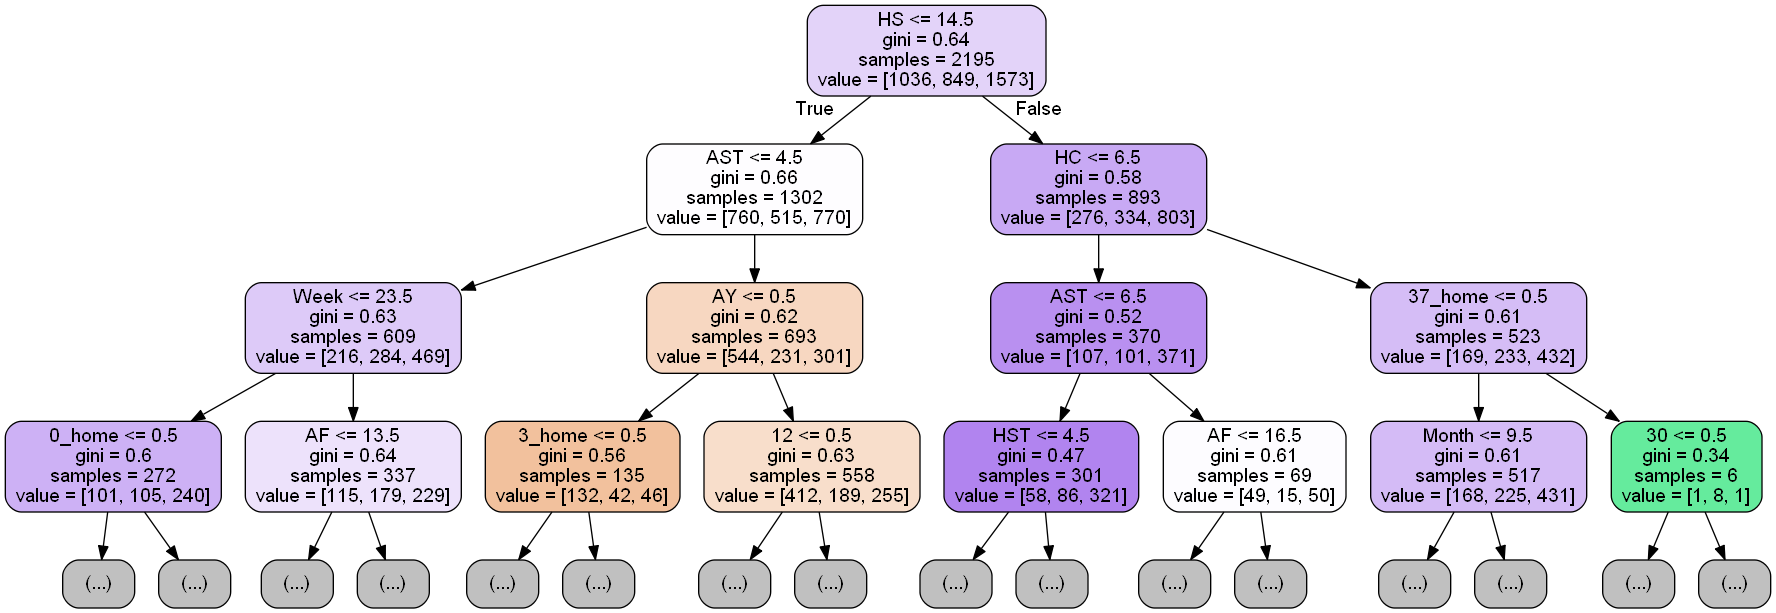

In [9]:
#Print rf tree N.B. may not work without importing graphviz, random forest images will be on GitHub
Image(filename = rf_tree_visualiser(rf, 'featureSetTree', data_filtered.columns))

### 3.1.6 Training model without Referee
<a name='section316'></a>

In [10]:
#Train model without Referee feature
data_filtered_no_ref = data_filtered.iloc[:, 0:15].join(data_filtered.iloc[:, 58:])
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_ref, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Referee: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")
#Ref is having negative impact so remove
data_filtered = data_filtered_no_ref

Accuracy without Referee: 57.962213225371116%
Difference from before: 0.13495276653171118%


### 3.1.7 Random Forest Tree without Referee
<a name='section317'></a>

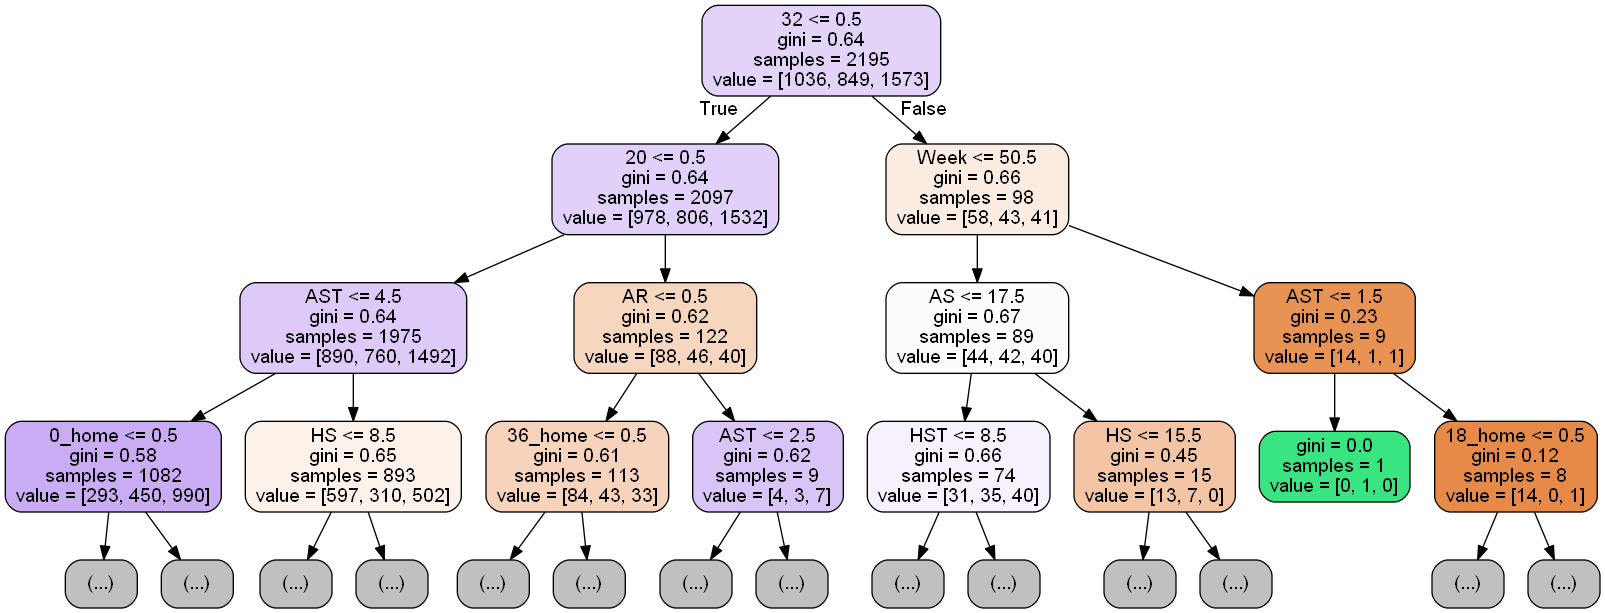

In [11]:
#Print rf tree (no ref)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoRef', data_filtered_no_ref.columns))

### 3.1.8 Training model without Date
<a name='section318'></a>

In [12]:
#Train model without Date feature
data_filtered_no_date = data_filtered.iloc[:, 3:]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_date, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Dates: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")

Accuracy without Dates: 56.81511470985156%
Difference from before: -1.012145748987848%


### 3.1.9 Random Forest Tree without Date
<a name='section319'></a>

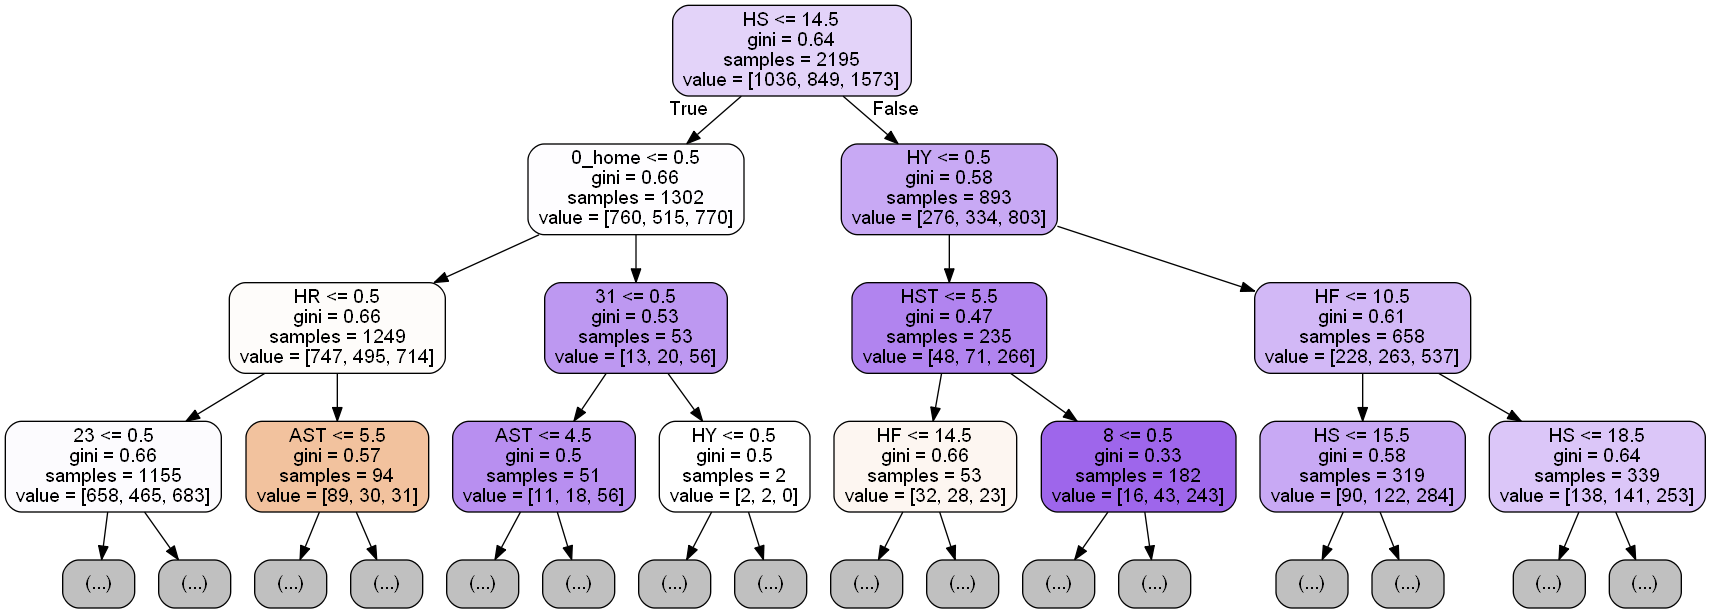

In [13]:
#Print rf tree (no dates)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoDate', data_filtered_no_date.columns))

### 3.1.10 Training model on only in-game stats
<a name='section3110'></a>

In [14]:
#Train model on only in-game stats to identify most important ones
data_filtered_only_game_stats = data_filtered.iloc[:, 3:15]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_only_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

Accuracy on all in-game stats: 55.06072874493927%


### 3.1.11 Visualising selected features
<a name='section3111'></a>

In [15]:
#Visualise and analyse initial results

#Display feature importances in descending order
feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))
#Important note: AF/HF rank higher than HC/AC

Feature Importances: 
Feature: HST                                 Importance: 0.13373568693956137
Feature: AST                                 Importance: 0.11086929727346594
Feature: HS                                  Importance: 0.10711965963253876
Feature: AS                                  Importance: 0.10459574408160308
Feature: AF                                  Importance: 0.10278875719257885
Feature: HF                                  Importance: 0.10274903136845186
Feature: HC                                  Importance: 0.09664473425445547
Feature: AC                                  Importance: 0.09167319027635455
Feature: AY                                  Importance: 0.06454575651360132
Feature: HY                                  Importance: 0.0615627757744895
Feature: AR                                  Importance: 0.012278852078380604
Feature: HR                                  Importance: 0.011436514614518712

Confusion Matrix: 
[[244  46 127]
 [134  50 186]
 [1

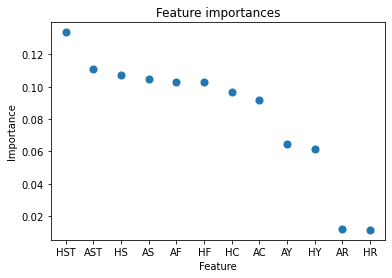

In [16]:
# Visualise feature importance
scatter(feature_importances, "Feature importances", "Feature", "Importance")

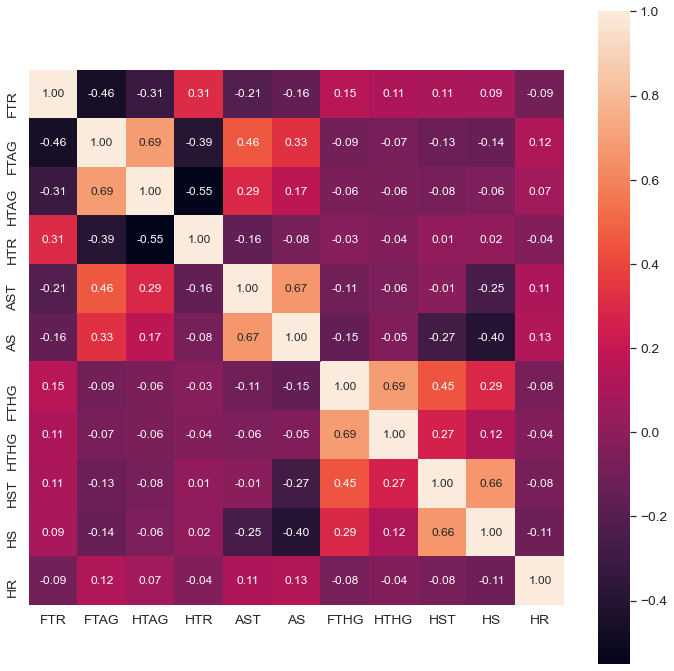

In [17]:
# plot Pearson Correlation Heatmap to see the top 10 features related to the match result FTR

def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)


In [18]:
#Feature Selection
#change names and display selected features more nicely, ideally with their importance, gini impurity...
selected_feat = select_feat(X_train, y_train)
print(selected_feat)

Index(['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC'], dtype='object')


In [19]:
#Train model on selected in-game stats only
indexes = []
for feat in selected_feat:
    indexes.append(data_filtered_only_game_stats.columns.get_loc(feat))
    
data_filtered_filtered_game_stats = data_filtered_only_game_stats.iloc[:, indexes]

X_train, X_test, y_train, y_test = train_test_split(data_filtered_filtered_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, reduced_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on reduced in-game stats: " + str(reduced_stats_accuracy) + "%")
print("Difference compared to all in-game stats: " + str(reduced_stats_accuracy - all_stats_accuracy) + "%")

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))

Accuracy on reduced in-game stats: 54.79082321187584%
Difference compared to all in-game stats: -0.26990553306342946%

Confusion Matrix: 
[[234  39 144]
 [107  64 199]
 [118  63 514]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       417
           1       0.39      0.17      0.24       370
           2       0.60      0.74      0.66       695

    accuracy                           0.55      1482
   macro avg       0.50      0.49      0.48      1482
weighted avg       0.52      0.55      0.52      1482



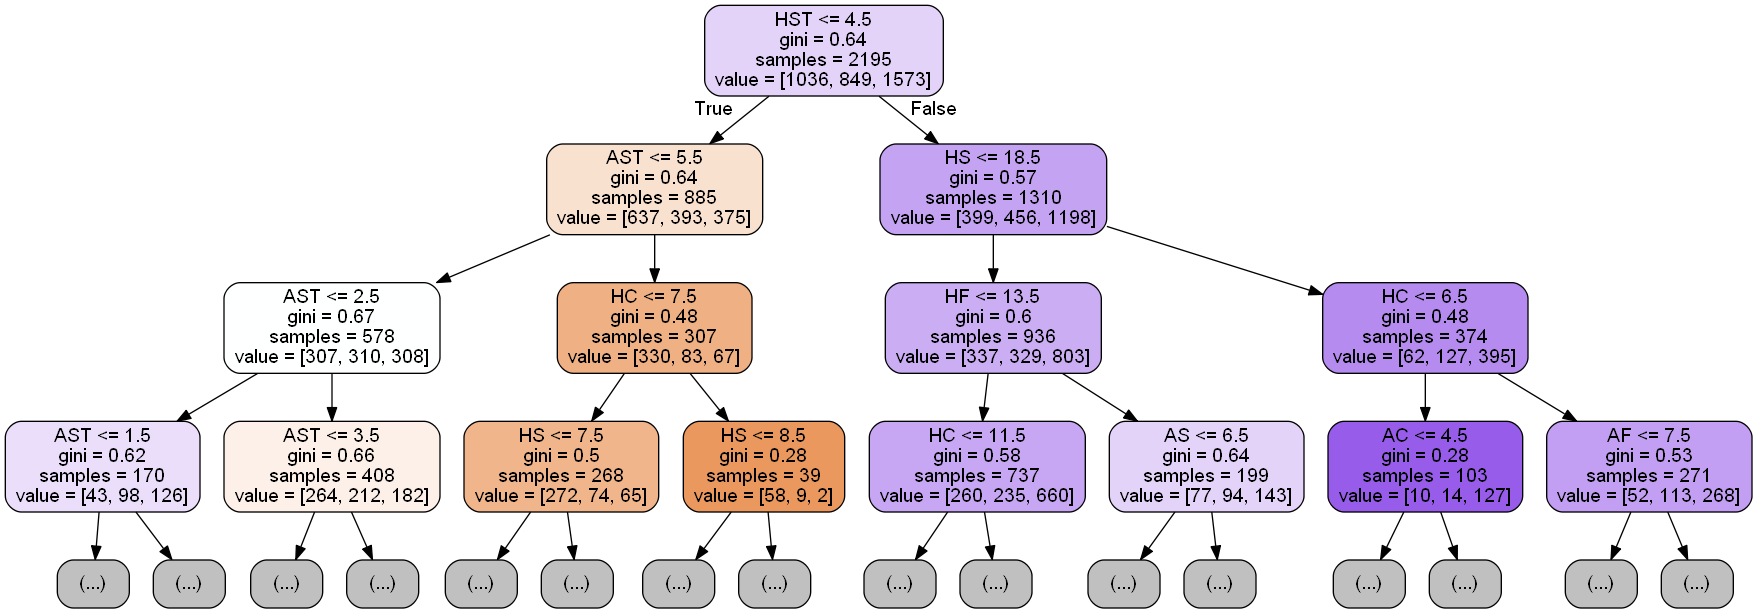

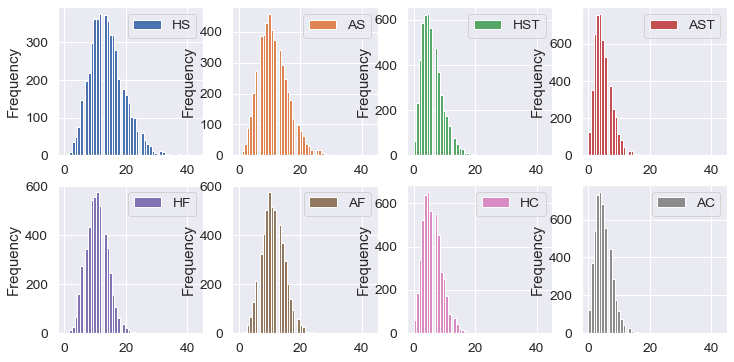

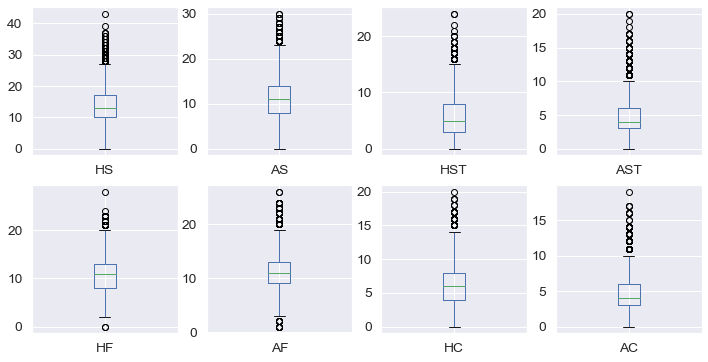

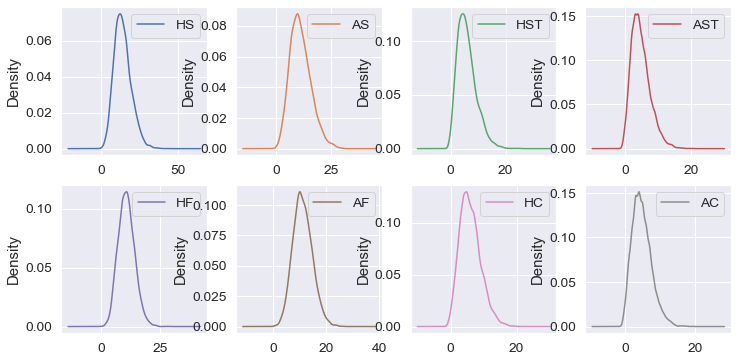

In [20]:
#Visualisation of new featureset/tree
data_filtered_filtered_game_stats.plot(kind='hist', subplots=True, sharex=False, sharey=False, bins=50, layout=(2,4), figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='density', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
Image(filename = rf_tree_visualiser(rf, 'selectedFeatureSetTree', data_filtered_filtered_game_stats.columns))

In [21]:
#Produce new dataset
#Fix column names
#Restack teams and dates

#Original teams are needed to be able to compute priors
data_new = data.iloc[:, [1, 2]].join(data_filtered_filtered_game_stats)
data_new = dates_split.join(data_new)

#Stack previously removed giveaway columns
data_new = data_new.join(data.iloc[:, [3, 4, 5, 6, 7, 8]])

#Feature engineer second half goals
#Second half home goals
SHHG = np.array(data.iloc[:, [3]]) - np.array(data.iloc[:, [6]])
#Second half away goals
SHAG = np.array(data.iloc[:, [4]]) - np.array(data.iloc[:, [7]])
data_new['SHHG'] = pd.DataFrame(SHHG)
data_new['SHAG'] = pd.DataFrame(SHAG)
data_new.columns = data_new.columns.astype(str)
data_new.head()

Month  Week  Day       HomeTeam   AwayTeam  HS  AS  HST  AST  HF  AF  HC  \
0      8    33   16        Arsenal  West Brom  24   5   14    4  11   8   7   
1      8    33   16         Bolton      Stoke  14   8    8    2  13  12   4   
2      8    33   16        Everton  Blackburn  10  15    5   11  11   9   3   
3      8    33   16           Hull     Fulham  11  12    6    6  10   9   5   
4      8    33   16  Middlesbrough  Tottenham  14   8   10    5  11  12   7   

   AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHAG  
0   5     1     0   H     1     0   H     0     0  
1   3     3     1   H     3     0   H     0     1  
2   5     2     3   A     1     1   D     1     2  
3   6     2     1   H     1     1   D     1     0  
4   9     2     1   H     0     0   D     2     1

In [22]:
#See if second half goals have significant correlation to total goals
highest_corr = corr_matrix(data_new, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data_new, "FTAG")
print("FTAG: \n" + str(highest_corr))
#Second half goals do have very strong correlation

FTHG: 
HS      0.291868
HST     0.447116
FTHG    1.000000
HTHG    0.686279
SHHG    0.769173
Name: FTHG, dtype: float64
FTAG: 
AS      0.329803
AST     0.455887
FTAG    1.000000
HTAG    0.689755
SHAG    0.777641
Name: FTAG, dtype: float64


## 3.2 Priors Feature Construction
<a name='section32'></a>

In [23]:
# From Pearson Correlation Heatmap to extract the top 10 features 
# there are two pairs of data highly correlated (see details in report), 
# so we just pick [FTHG, FTAG, HS, AS, HR, AR] from the top 10 features,
# additionally [Date, HomeTeam, AwayTeam, FTR], to derive our features.
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = data[selectedAttributes]

### 3.2.1 Data Cleaning
<a name='section321'></a>

In [24]:
#Derive features and remove unwanted data
def removeInvalidData(data):

    # remove data which contains None
    data.dropna(axis=0, how='any',inplace=True)

    # remove data which contains NaN, infinite or overflowed number 
    indices_to_keep = ~data.isin([np.nan, np.inf, -np.inf]).any(1)
    data = data[indices_to_keep]

    return data

#check if there are rows containing None, NaN, infinite or overflowed values
assert data.shape[0] == removeInvalidData(data).shape[0]
data = removeInvalidData(data)


### 3.2.2 Cumulative Full-time W/L Ratio
<a name='section322'></a>

In [25]:
# Computing Priors
# Calculate cumulative Full-Time win-loss ratio for Home/Away teams prior to every match
# TODO: Points-based results based on previous wins & losses 
# PHWL = Previous Home Team Win Loss Ratio
# PAWL = Previous Away Team Win Loss Ratio

def get_previousFTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    PHWL = []
    PAWL = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].FTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
       
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
        
        #Home/Away cumulative WL ratios prior to every match
        PHWL.append(h_wlRatio)
        PAWL.append(a_wlRatio)
        
    data_new.loc[:,'PHWL'] = pd.Series(PHWL)
    data_new.loc[:,'PAWL'] = pd.Series(PAWL)

    return data_new
#get_previousFTResults(data_new)


###  3.2.3 Cumulative Half-time W/L Ratio
<a name='section323'></a>

In [26]:
# Computing Priors
# Calculate cumulative Half-Time win-loss ratio for Home/Away teams prior to every match
# HHTR = Previous Home Half Time Results
# AHTR = Previous Away Half Time Results

def get_PreviousHTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    HHTR = []
    AHTR = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].HTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].HTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
            
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
       
        #Home/Away cumulative WL ratios prior to every match
        HHTR.append(h_wlRatio)
        AHTR.append(a_wlRatio)
        
    data_new.loc[:,'HHTR'] = pd.Series(HHTR)
    data_new.loc[:,'AHTR'] = pd.Series(AHTR)

    return data_new


#get_PreviousHTResults(data_new)

### 3.2.4 Cumulative Full-Time goals scored
<a name='section324'></a>

In [27]:
# Computing Priors
# Calculate Previous Full-Time Cumulative Goal 
# PHGS = Previous Home Goal Scored
# PAGS = Previous Away Goal Scored

def getPreviousCumulativeGoals(data):
    teams = {}
    PHGS = [] 
    PAGS = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']

        try:
            pcgs_h = teams[data.iloc[i].HomeTeam].pop()
            pcgs_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcgs_h = 0
            pcgs_a = 0

        PHGS.append(pcgs_h)
        PAGS.append(pcgs_a)
#         print(PAGS)
#         print(PHGS)
        pcgs_h = pcgs_h + FTHG #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcgs_h)
        pcgs_a = pcgs_a + FTAG #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcgs_a)

    data_new.loc[:,'PHGS'] = pd.Series(PHGS)
    data_new.loc[:,'PAGS'] = pd.Series(PAGS)
    return data_new

#getPreviousCumulativeGoals(data_new)

### 3.2.5 Cumulative Half-time W/L Ratio
<a name='section325'></a>

In [28]:
# Computing Priors
# Calculate Previous Shots in the match
# PHS = Home teams previous match Shots, totaled over season
# PAS = Away teams previous match Shots, totaled over season

def getPreviousShots(data):
    teams = {}
    PHS = [] 
    PAS = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HS = data.iloc[i]['HS']
        AS = data.iloc[i]['AS']

        try:
            pcs_h = teams[data.iloc[i].HomeTeam].pop()
            pcs_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcs_h = 0
            pcs_a = 0

        PHS.append(pcs_h)
        PAS.append(pcs_a)
        pcs_h = pcs_h + HS #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcs_h)
        pcs_a = pcs_a + AS #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcs_a)

    data_new.loc[:,'PHS'] = pd.Series(PHS)
    data_new.loc[:,'PAS'] = pd.Series(PAS)
    return data_new

#getPreviousShots(data_new)

### 3.2.6 Previous shots on target
<a name='section326'></a>

In [29]:
# Computing Priors
# Calculate Previous Shots on Target
# PHSOT = Home teams Previous Shots on Target, totaled over season
# PASOT = Away teams Previous Shots on Target, totaled over season

def getPreviousShotsOnTarget(data):
    teams = {}
    PHSOT = [] 
    PASOT = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HST = data.iloc[i]['HST']
        AST = data.iloc[i]['AST']

        try:
            pcsot_h = teams[data.iloc[i].HomeTeam].pop()
            pcsot_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcsot_h = 0
            pcsot_a = 0

        PHSOT.append(pcsot_h)
        PASOT.append(pcsot_a)
        pcsot_h = pcsot_h + HST #Home team's previous goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pcsot_h)
        pcsot_a = pcsot_a + AST #Away team's previous goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pcsot_a)

    data_new.loc[:,'PHSOT'] = pd.Series(PHSOT)
    data_new.loc[:,'PASOT'] = pd.Series(PASOT)
    return data_new

#getPreviousShotsOnTarget(data_new)

### 3.2.7 Computing previous fouls
<a name='section327'></a>

In [30]:
# Computing Priors
# Calculate Previous Fouls
# PHTF = Home teams Previous Fouls, Totaled over season
# PATF = Away teams Previous Fouls, Totaled over season

def getPreviousTeamFouls(data):
    teams = {}
    PHTF = [] 
    PATF = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HF = data.iloc[i]['HF']
        AF = data.iloc[i]['AF']

        try:
            pcf_h = teams[data.iloc[i].HomeTeam].pop()
            pcf_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcf_h = 0
            pcf_a = 0

        PHTF.append(pcf_h)
        PATF.append(pcf_a)
        pcf_h = pcf_h + HF #Home team's previous fouls before this match
        teams[data.iloc[i].HomeTeam].append(pcf_h)
        pcf_a = pcf_a + AF #Away team's previous fouls before this match
        teams[data.iloc[i].AwayTeam].append(pcf_a)

    data_new.loc[:,'PHTF'] = pd.Series(PHTF)
    data_new.loc[:,'PATF'] = pd.Series(PATF)
    return data_new

#getPreviousTeamFouls(data_new)

### 3.2.8 Computing previous corners
<a name='section328'></a>

In [31]:
# Computing Priors
# Calculate Previous Corners
# PHTC = Home teams Previous Corners, Totaled over season
# PATC = Away teams Previous Corners, Totaled over season

def getPreviousTeamCorners(data):
    teams = {}
    PHTC = [] 
    PATC = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HC = data.iloc[i]['HC']
        AC = data.iloc[i]['AC']

        try:
            pcc_h = teams[data.iloc[i].HomeTeam].pop()
            pcc_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pcc_h = 0
            pcc_a = 0

        PHTC.append(pcc_h)
        PATC.append(pcc_a)
        pcc_h = pcc_h + HC #Home team's previous corners before this match
        teams[data.iloc[i].HomeTeam].append(pcc_h)
        pcc_a = pcc_a + AC #Away team's previous corners before this match
        teams[data.iloc[i].AwayTeam].append(pcc_a)

    data_new.loc[:,'PHTC'] = pd.Series(PHTC)
    data_new.loc[:,'PATC'] = pd.Series(PATC)
    return data_new

#getPreviousTeamCorners(data_new)

### 3.2.9 Computing previous goals before half-time
<a name='section329'></a>

In [32]:
# Computing Priors
# Calculate Previous Goals before half time
# PHTHG = Home teams Previous Goals Before Half Time, Totaled over season
# PHTAG = Away teams Previous Goals Before Half Time, Totaled over season

def getPreviousHalfTimeGoalsScored(data):
    teams = {}
    PHTHG = [] 
    PHTAG = []   

    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            pchtg_h = teams[data.iloc[i].HomeTeam].pop()
            pchtg_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pchtg_h = 0
            pchtg_a = 0

        PHTHG.append(pchtg_h)
        PHTAG.append(pchtg_a)
        pchtg_h = pchtg_h + HTHG #Home team's previous first half goals scored before this match
        teams[data.iloc[i].HomeTeam].append(pchtg_h)
        pchtg_a = pchtg_a + HTAG #Away team's previous first half goals scored before this match
        teams[data.iloc[i].AwayTeam].append(pchtg_a)

    data_new.loc[:,'PHTHG'] = pd.Series(PHTHG)
    data_new.loc[:,'PHTAG'] = pd.Series(PHTAG)
    return data_new

#getPreviousHalfTimeGoalsScored(data_new)

### 3.2.10 Compute previous goals after half-time
<a name='section3210'></a>

In [33]:
# Computing Priors
# Calculate Previous Second Half Time Goals in the match
# PSHHG = Previous Second Half Time Goals scored by Home team, totaled over season
# PSHAG = Previous Second Half Time Goals scored by Away team, totaled over season

def getPreviousSecondHalfGoals(data):
    teams = {}
    PSHHG = [] 
    PSHAG = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                
        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']
        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            shg_h = teams[data.iloc[i].HomeTeam].pop()
            shg_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            shg_h = 0
            shg_a = 0

        PSHHG.append(shg_h)
        PSHAG.append(shg_a)
        shg_h = shg_h + (FTHG - HTHG) #Home team's previous second half goals scored before this match
        teams[data.iloc[i].HomeTeam].append(shg_h)
        shg_a = shg_a + (FTAG - HTAG) #Away team's previous second half goals scored before this match
        teams[data.iloc[i].AwayTeam].append(shg_a)

    data_new.loc[:,'PSHHG'] = pd.Series(PSHHG)
    data_new.loc[:,'PSHAG'] = pd.Series(PSHAG)
    return data_new

#getPreviousSecondHalfGoals(data_new)

### 3.2.11 Computing previous goals conceded before half-time
<a name='section3211'></a>

In [34]:
# Computing Priors
# Calculate previous goals conceded before half-time
# PHTHGC = Home Team Previous Goals Conceded Before Half Time, totaled over season
# PHTAGC = Away Team Previous Goals Conceded Before Half Time, Totaled over season

def getPreviousHalfTimeGoalConceded(data):
    teams = {}
    PHTHGC = [] 
    PHTAGC = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                      
        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            phtgc_h = teams[data.iloc[i].HomeTeam].pop()
            phtgc_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            phtgc_h = 0
            phtgc_a = 0

        PHTHGC.append(phtgc_h)
        PHTAGC.append(phtgc_a)
        phtgc_h = phtgc_h + HTAG #Home team's previous half time goals conceded before this match
        teams[data.iloc[i].HomeTeam].append(phtgc_h)
        phtgc_a = phtgc_a + HTHG #Away team's previous half time goals conceded before this match
        teams[data.iloc[i].AwayTeam].append(phtgc_a)

    data_new.loc[:,'PHTHGC'] = pd.Series(PHTHGC)
    data_new.loc[:,'PHTAGC'] = pd.Series(PHTAGC)
    return data_new

#getPreviousHalfTimeGoalConceded(data_new)

### 3.2.12 Computing previous goals conceded after half-time
<a name='section3212'></a>

In [35]:
# Computing Priors
# Calculate previous goals conceded after half-time
# PSHHGC = Previous second half home team goals conceded, totaled over season
# PSHAGC = Previous second half away team goals conceded, totaled over season

def getPreviousSecondHalfGoalConceded(data):
    teams = {}
    PSHHGC = [] 
    PSHAGC = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
  
        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']   
        HTHG = data.iloc[i]['HTHG']
        HTAG = data.iloc[i]['HTAG']

        try:
            pshhgc_h = teams[data.iloc[i].HomeTeam].pop()
            pshhgc_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pshhgc_h = 0
            pshhgc_a = 0

        PSHHGC.append(pshhgc_h)
        PSHAGC.append(pshhgc_a)
        pshhgc_h = pshhgc_h + (FTAG - HTAG) #Home team's previous half time goals conceded before this match
        teams[data.iloc[i].HomeTeam].append(pshhgc_h)
        pshhgc_a = pshhgc_a + (FTHG - HTHG) #Away team's previous half time goals conceded before this match
        teams[data.iloc[i].AwayTeam].append(pshhgc_a)

    data_new.loc[:,'PSHHGC'] = pd.Series(PSHHGC)
    data_new.loc[:,'PSHAGC'] = pd.Series(PSHAGC)
    return data_new

#getPreviousSecondHalfGoalConceded(data_new)

### 3.2.13 Matches Played
<a name='section3213'></a>

In [36]:
# Computing Priors ***NOT WORKING***
# Calculate previous goals conceded after half-time
# PMPH = Previous total matches played for home team
# PMPA = Previous total matches played for away team
def getPreviousMatchesPlayed(data):
    teams = {}
    PMPH = [] 
    PMPA = []   
    
    # for each match
    for i in range(len(data)):
        if (i % 100000 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        try:
            pmp_h = teams[data.iloc[i].HomeTeam].pop()
            pmp_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            pmp_h = 0
            pmp_a = 0

        PMPH.append(pmp_h)
        PMPA.append(pmp_a)
        pmp_h = pmp_h + 1 #Home team's previous number matches played
        teams[data.iloc[i].HomeTeam].append(pmp_h)
        pmp_a = pmp_a + 1 #Away team's previous number matches played
        teams[data.iloc[i].AwayTeam].append(pmp_a)

    data_new.loc[:,'PMPH'] = pd.Series(PMPH)
    data_new.loc[:,'PMPA'] = pd.Series(PMPA)
    return data_new

#print(getPreviousMatchesPlayed(data_new))

## 3.3 Additional Features
<a name='section33'></a>

### 3.3.1 Distance Travelled for Away Teams
<a name='section331'></a>

In [37]:
# Distance needed for away teams to travel to playing stadiums(in km)
# The locationData contains the latitude and longitude of teams
def getDistance(data, locationData):
  array = []
  for x in data.iterrows():
   
    home_lat = (locationData.loc[locationData['Team'] == x[1].HomeTeam]).Latitude
    home_long = (locationData.loc[locationData['Team'] == x[1].HomeTeam]).Longitude
    home_location = (np.float32(home_lat), np.float32(home_long))
    
    away_lat = (locationData.loc[locationData['Team'] == x[1].AwayTeam]).Latitude
   
    away_long = (locationData.loc[locationData['Team'] == x[1].AwayTeam]).Longitude
    away_location = (np.float32(away_lat), np.float32(away_long))
    array.append(np.float32(geodesic(home_location, away_location).km))
  
  
  ADIS = pd.Series(array)
  data.loc[:,'ADIS'] = ADIS

  return data

#getDistance(data, locationData)

### 3.3.2 Average shots on goal in the past 3 matches
<a name='section332'></a>

In [38]:
# Average shots on goal for the past 3 matches
# HAS, AAS
def getPreviousShotOnGoal_3(data):
    teams = {}
    HAS = [] 
    AAS = []   
    
    for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None]) #[3rd, 2nd, latest data]
            
    # for each match
    for i in range(len(data)):

            
        try:
            as_h = np.mean(teams[data.iloc[i].HomeTeam])
            as_a = np.mean(teams[data.iloc[i].AwayTeam])
        except:
            as_h = None
            as_a = None

        HAS.append(as_h)
        AAS.append(as_a)

        teams[data.iloc[i].HomeTeam].popleft()
        teams[data.iloc[i].HomeTeam].append(data.iloc[i].HS)

        teams[data.iloc[i].AwayTeam].popleft()
        teams[data.iloc[i].AwayTeam].append(data.iloc[i].AS)

    data.loc[:,'HAS'] = pd.Series(HAS)
    data.loc[:,'AAS'] = pd.Series(AAS)

    return data

#getPreviousShotOnGoal_3(data)

### 3.3.3 WL Performance of past 3 matches
<a name='section333'></a>

In [39]:
# Performance of Home-Away teams in past 3 matches
# HM1, AM1, HM2, AM2, HM3, AM3
def getPerformanceOfLast3Matches(data):
    HM1 = []    # performance of the last match of home team
    AM1 = []    # performance of the last match of away team

    HM2 = []    # performance of the 2nd last match of home team
    AM2 = []

    HM3 = []    # performance of the 3rd last match of home team
    AM3 = []

    teams = {}
    
    for name in data.groupby('HomeTeam').mean().T.columns:
               teams[name] = deque([None, None, None])  #[3rd, 2nd, latest data]

    for i in range(len(data)):
        

        HM3.append(teams[data.iloc[i].HomeTeam].popleft())
        AM3.append(teams[data.iloc[i].AwayTeam].popleft())
        HM2.append(teams[data.iloc[i].HomeTeam][0])
        AM2.append(teams[data.iloc[i].AwayTeam][0])
        HM1.append(teams[data.iloc[i].HomeTeam][1])
        AM1.append(teams[data.iloc[i].AwayTeam][1])

        if data.iloc[i].FTR == 'H':
            teams[data.iloc[i].HomeTeam].append('W')
            teams[data.iloc[i].AwayTeam].append('L')
        elif data.iloc[i].FTR == 'A':
            teams[data.iloc[i].AwayTeam].append('W')
            teams[data.iloc[i].HomeTeam].append('L')
        else:
            teams[data.iloc[i].AwayTeam].append('D')
            teams[data.iloc[i].HomeTeam].append('D')

    data.loc[:,'HM1'] = HM1
    data.loc[:,'AM1'] = AM1
    data.loc[:,'HM2'] = HM2
    data.loc[:,'AM2'] = AM2
    data.loc[:,'HM3'] = HM3
    data.loc[:,'AM3'] = AM3

    return data

#print(getPerformanceOfLast3Matches(data))

### 3.3.4 Cumulative Full Time Goal Difference
<a name='section334'></a>

In [40]:
# Computing Priors
# Calculate cumulative Full-Time goal different for Home/Away teams prior to every match
# HCGD = Home Cumulative Goal Difference
# ACGD = Away Cumulative Goal Difference
def getCumulativeGoalsDiff(data):
    teams = {}
    HCGD = [] 
    ACGD = []   

    # for each match
    for i in range(len(data)):
        # as the result in 3.2.1 shows that the number of matchese per season is always the same, so here we simply use i%380==0 to check if it is a new season and to initialize the feature.
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']

        try:
            cgd_h = teams[data.iloc[i].HomeTeam].pop()
            cgd_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            cgd_h = 0
            cgd_a = 0

        HCGD.append(cgd_h)
        ACGD.append(cgd_a)
        cgd_h = cgd_h + FTHG - FTAG
        teams[data.iloc[i].HomeTeam].append(cgd_h)
        cgd_a = cgd_a + FTAG - FTHG
        teams[data.iloc[i].AwayTeam].append(cgd_a)

    data.loc[:,'HCGD'] = pd.Series(HCGD)
    data.loc[:,'ACGD'] = pd.Series(ACGD)

    return data

#getCumulativeGoalsDiff(data)

### 3.3.5 Goalkeeper Stats
<a name='section335'></a>

In [41]:
# # Goalkeeping stats for each team for season starting 2008/2009, ending at present (2021/2020)
# def getGK(data, GKData):
    
#     teams = {}
#     HSaveP = [] #Save percentage (Home team)
#     HCSP   = [] #Clean sheet percentage
#     ASaveP = [] 
#     ACSP   = [] 
    
#     ## Split data into seasons
#     data2008 = data.iloc[:379,:] # 2008-2009 season
#     data2009 = data.iloc[380:759,:]
#     data2010 = data.iloc[760:1139,:]
#     data2011 = data.iloc[1140:1519,:]
#     data2012 = data.iloc[1520:1899,:]
#     data2013 = data.iloc[1900:2279,:]
#     data2014 = data.iloc[2280:2659,:]
#     data2015 = data.iloc[2660:3039,:]
#     data2016 = data.iloc[3040:3419,:]
#     data2017 = data.iloc[3420:3799,:]
#     data2018 = data.iloc[3800:4179,:]
#     data2019 = data.iloc[4180:4559,:]
#     data2020 = data.iloc[4560:4939,:] #2020-2021 season
    
#     GKData2008 = GKData.iloc[:19,:] # 2008-2009 season
#     GKData2009 = GKData.iloc[20:39,:]
#     GKData2010 = GKData.iloc[40:59,:]
#     GKData2011 = GKData.iloc[60:79,:]
#     GKData2012 = GKData.iloc[80:99,:]
#     GKData2013 = GKData.iloc[100:119,:]
#     GKData2014 = GKData.iloc[120:139,:]
#     GKData2015 = GKData.iloc[140:159,:]
#     GKData2016 = GKData.iloc[160:179,:]
#     GKData2017 = GKData.iloc[180:199,:]
#     GKData2018 = GKData.iloc[200:219,:]
#     GKData2019 = GKData.iloc[220:239,:]
#     GKData2020 = GKData.iloc[240:259,:] #2020-2021 season

#     for i in data.groupby('HomeTeam').mean().T.columns: #for 2009 season
#             teams[i] = [] #Each team gets their own list

#     # the value corresponding to keys is a list containing the match result

#     for i in range(len(GKData2008)): # i think swap this for data instead and figure how to go through gkdata 1 at a time
#         if GKData2008.iloc[i].Squad == data2008.iloc[i].HomeTeam:
#             teams[data2008.iloc[i].HomeTeam].append(GKData2008[["SavePercentage","CSPercentage"]].iloc[i])
#     print(teams)
#     print(len(GKData2008))
        
# #         SAVEP = teams[data2009.iloc[i].HomeTeam] #use 2008 season gk data
# #         CSP = teams[data2009.iloc[i].HomeTeam]

# #         HSaveP.append(SAVEP)
# #         HCSP.append(CSP)
# #         ASaveP.append(SAVEP)
# #         ACSP.append(CSP)
        
# #         teams[data2009.iloc[i].HomeTeam].append(SAVEP)
# #         teams[data2009.iloc[i].HomeTeam].append(CSP)
# #         teams[data2009.iloc[i].AwayTeam].append(SAVEP)
# #         teams[data2009.iloc[i].AwayTeam].append(CSP)

# #         data2009.loc[:,'HSaveP'] = pd.Series(HSaveP)
# #         data2009.loc[:,'HCSP'] = pd.Series(HCSP)
# #         data2009.loc[:,'ASaveP'] = pd.Series(ASaveP)
# #         data2009.loc[:,'ACSP'] = pd.Series(ACSP)
#     return data2009

# getGK(data, GKData)

### Priors - extra features pulled

In [42]:
def add_pickled_to_df(df,filename,column):
    matrix = pd.read_pickle(filename)
    matrix[2008] = np.NaN
#     print(matrix)
    difference = []
    for i in range(0,len(data_new)):
    #     print(ratings_matrix["mean"].loc[data_new["HomeTeam"].iloc[i]])
        if pd.isnull(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]) or pd.isnull(matrix[year[i]].loc[df["AwayTeam"].iloc[i]]):
            difference.append(np.nan)
            
        else:
            difference.append(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]-matrix[year[i]].loc[df["AwayTeam"].iloc[i]])

#     for i in range(0,len(difference)):
#         if difference[i]<-0.1:
#             difference[i]='A'
#         elif difference[i]>0.1:
#             difference[i]='H'
#         else:
#             difference[i]='D'

    df[column]=difference
    return df

### We have decided not to include these scraped features due to the many missing values without a reliable way to impute them.

In [43]:
# import glob
# files = glob.glob("./Pickles/*")
# for file in files:
#     name = file.split("\\")[-1].split(".")[0].replace("DF","")
#     data_new = add_pickled_to_df(data_new,file,name)

# data_new

## 3.4 Derive Priors
<a name='section34'></a>

In [44]:
def DerivePriors(data_new):
    #get_previousFTResults(data_new) # dont want Full time results in the test data
    get_PreviousHTResults(data_new)
    getPreviousCumulativeGoals(data_new)
    getPreviousShots(data_new)
    getPreviousShotsOnTarget(data_new)
    getPreviousTeamFouls(data_new)
    getPreviousTeamCorners(data_new)
    getPreviousHalfTimeGoalsScored(data_new)
    getPreviousSecondHalfGoals(data_new)
    getPreviousHalfTimeGoalConceded(data_new)
    getPreviousSecondHalfGoalConceded(data_new)
    getPreviousMatchesPlayed(data_new)
    getDistance(data_new, locationData)
    getPreviousShotOnGoal_3(data_new)
    getPerformanceOfLast3Matches(data_new)
    getCumulativeGoalsDiff(data_new)
    #getGK(data, GKData)
    return data_new

In [45]:
## Remove First Initial Season
data_new = DerivePriors(data_new).iloc[380:] #chop off first season 
y=np.delete(y,slice(0,380),axis=0)
data_new.reset_index(drop=True, inplace=True)
data_new 

Month  Week  Day          HomeTeam        AwayTeam  HS  AS  HST  AST  \
0         8    33   15       Aston Villa           Wigan  11  14    5    7   
1         8    33   15         Blackburn        Man City  17   8    9    5   
2         8    33   15            Bolton      Sunderland  11  20    3   13   
3         8    33   15           Chelsea            Hull  26   7   12    3   
4         8    33   15           Everton         Arsenal   8  15    5    9   
...     ...   ...  ...               ...             ...  ..  ..  ...  ...   
4555      5    20   23         Liverpool  Crystal Palace  19   5    5    4   
4556      5    20   23          Man City         Everton  21   8   11    3   
4557      5    20   23  Sheffield United         Burnley  12  10    3    3   
4558      5    20   23          West Ham     Southampton  14  17    7    5   
4559      5    20   23            Wolves      Man United  14   9    4    4   

      HF  AF  HC  AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHAG      HHTR  \
0     15  14   4   6     0     2   A     0     1   A     0     1  0.333333   
1     12   9   5   4     0     2   A     0     1   A     0     1  0.205128   
2     16  10   4   7     0     1   A     0     1   A     0     0  0.256410   
3     13  15  12   4     2     1   H     1     1   D     1     0  0.487179   
4     11  13   4   9     1     6   A     0     3   A     1     3  0.282051   
...   ..  ..  ..  ..   ...   ...  ..   ...   ...  ..   ...   ...       ...   
4555  10   8  14   1     2     0   H     1     0   H     1     0  0.421053   
4556   8  10   7   5     5     0   H     2     0   H     3     0  0.504049   
4557  11   1   8   9     1     0   H     1     0   H     0     0  0.184211   
4558   5   9   2   3     3     0   H     2     0   H     1     0  0.291667   
4559  14   3   6   2     1     2   A     1     2   A     0     0  0.210526   

          AHTR  PHGS  PAGS   PHS   PAS  PHSOT  PASOT  PHTF  PATF  PHTC  PATC  \
0     0.307692    54    34   408   483    225    227   431   439   260   216   
1     0.358974    40    58   404   489    219    267   501   456   198   212   
2     0.179487    41    34   441   396    244    210   497   380   197   174   
3     0.128205    68    39   656   416    359    213   417   533   236   188   
4     0.384615    55    68   423   554    232    316   473   419   193   268   
...        ...   ...   ...   ...   ...    ...    ...   ...   ...   ...   ...   
4555  0.226974   933   337  7784  3442   3373   1116  5034  3502  3263  1543   
4556  0.295547  1067   690  7948  6228   3431   2725  5168  5522  3419  2691   
4557  0.203008    58   266   667  2725    211    976   858  2770   375  1140   
4558  0.292398   581   437  5439  4414   2202   1598  4869  3836  2295  1858   
4559  0.447368   251   906  2540  7031   1088   3241  2492  5467  1245  2988   

      PHTHG  PHTAG  PSHHG  PSHAG  PHTHGC  PHTAGC  PSHHGC  PSHAGC  PMPH  PMPA  \
0        23     18     31     16      22      17      26      28    38    38   
1        17     28     23     30      26      16      34      34    38    38   
2        23     14     18     20      21      21      32      33    38    38   
3        32     15     36     24       8      34      16      30    38    38   
4        20     27     35     41      13      14      24      23    38    38   
...     ...    ...    ...    ...     ...     ...     ...     ...   ...   ...   
4555    423    130    510    207     228     182     286     253   493   303   
4556    488    308    579    382     193     267     270     335   493   493   
4557     25    121     33    145      42     188      60     213    75   265   
4558    269    208    312    229     285     218     394     256   455   341   
4559     98    412    153    494     171     204     169     266   227   493   

            ADIS        HAS        AAS HM1 AM1 HM2 AM2 HM3 AM3  HCGD  ACGD  
0     126.579201  10.000000  13.333333   W   W   D   L   L   L     0     0  
1      33.360867   8.666667  13.333333   D   W   L   L  

### 3.5 Final Data Preprocessing
<a name='section35'></a>

In [46]:
#Final data preprocessing

# TODO:
# Implement dates using trig - done
# Add one hot encoded teams - done
# Compute custom features using priors (goals/shots on target, shots on target / total shots, home team fouls / away team fouls)
# PHGS/PHSOT, PAGS/PASOT & PHSOT/PHS, PASOT/PAS & PHTF/PATF - done
# Implement scaling but don't apply just yet - done
# Apply PCA - done

dates = data_new.iloc[:, 0:3]
month_sin = transformation(dates["Month"])[0]
month_cos = transformation(dates["Month"])[1]
week_sin = transformation(dates["Week"])[0]
week_cos = transformation(dates["Week"])[1]
day_sin = transformation(dates["Day"])[0]
day_cos = transformation(dates["Day"])[1]

teams = pd.DataFrame(home_t.toarray()).add_prefix("home_").join(pd.DataFrame(away_t.toarray()).add_prefix("away_"))

# Select only columns that contain priors, can't use in-game stats to predict the future
priors = data_new.iloc[:, 21:39]

# PHGS_PHSOT is ratio of home goals to home shots on target
PHGS_PHSOT = np.where(priors["PHSOT"] != 0, priors["PHGS"]/priors["PHSOT"], 0)
# PHGS_PHSOT is ratio of away goals to away shots on target
PAGS_PASOT = np.where(priors["PASOT"] != 0, priors["PAGS"]/priors["PASOT"], 0)
# PHSOT_PHS is ratio of home shots on target to home shots
PHSOT_PHS = np.where(priors["PHS"] != 0, priors["PHSOT"]/ (priors["PHS"] + priors["PHSOT"]), 0)
# PASOT_PAS is ratio of away shots on target to away shots
PASOT_PAS = np.where(priors["PAS"] != 0, priors["PASOT"]/ (priors["PAS"] + priors["PASOT"]), 0)
# PHTF_PATF is ratio of home fouls to away fouls
PHTF_PATF = np.where(priors["PATF"] != 0, priors["PHTF"]/priors["PATF"], 0)

# Building final dataset
X = pd.DataFrame()
X["month_cos"] = month_cos
X["month_sin"] = month_sin
X["week_cos"] = week_cos
X["week_sin"] = week_sin
X["day_cos"] = day_cos
X["day_sin"] = day_sin
X = X.join(teams).join(priors)
X["PHGS_PHSOT"] = PHGS_PHSOT.tolist()
X["PAGS_PASOT"] = PAGS_PASOT.tolist()
X["PHSOT_PHS"] = PHSOT_PHS.tolist()
X["PASOT_PAS"] = PASOT_PAS.tolist()
X["PHTF_PATF"] = PHTF_PATF.tolist()

### 3.5.1 Split Data
<a name='section351'></a>

In [47]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

y_train = np.array(y_train).reshape(len(y_train))
y_val = np.array(y_val).reshape(len(y_val))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


from tensorflow import keras
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)

In [48]:
#try without our custom features
rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy on all in-game stats: 47.80701754385965%
Feature Importances: 
Feature: HHTR                                Importance: 0.046584893208110316
Feature: AHTR                                Importance: 0.04443777541549793
Feature: PHSOT_PHS                           Importance: 0.036094867822470934
Feature: PASOT_PAS                           Importance: 0.03505468028131865
Feature: PASOT                               Importance: 0.034354260260714996
Feature: PHGS_PHSOT                          Importance: 0.034151812603948145
Feature: PAGS_PASOT                          Importance: 0.03339748810097317
Feature: PHSOT                               Importance: 0.0321408266284466
Feature: PAS                                 Importance: 0.0319925278738506
Feature: PHTF_PATF                           Importance: 0.0316353815009553
Feature: PSHHG                               Importance: 0.03149414889596408
Feature: PHTAG                               Importance: 0.031083072869095726
Fe

### 3.6 Scale data
<a name='section36'></a>

In [49]:
# Not sure if data needs to be scaled so just gonna leave this here
scaler = StandardScaler().fit(X_train.iloc[:, 82:])
X_train_scaled = scaler.transform(X_train.iloc[:, 82:])
X_test_scaled = scaler.transform(X_test.iloc[:, 82:])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train = np.array(X_train.iloc[:, 0:82])
X_test = np.array(X_test.iloc[:, 0:82])

X_train_scaled = np.hstack((X_train, X_train_scaled))
X_test_scaled = np.hstack((X_test, X_test_scaled))

# PCA
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# pca = PCA(0.95)
# pca.fit(X_train_scaled)
# X_train = pca.transform(X_train_scaled)
# X_test = pca.transform(X_test_scaled)

# pca = PCA(n_components=50)
# X = pca.fit_transform(X_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(X)

# from sklearn.manifold import MDS
# embedding = MDS(n_components=2)
# X = embedding.fit_transform(X) -> took way too long

# from sklearn.manifold import Isomap
# embedding = Isomap(n_components=2)
# X = embedding.fit_transform(X) -> gave terrible results

# import umap.umap_ as umap
# reducer = umap.UMAP(random_state=42,n_components=15)
# X = reducer.fit_transform(X_scaled) -> requires outdated numpy

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=15, kernel='rbf')
kpca.fit(X_train_scaled)
X_train = kpca.transform(X_train_scaled)
X_test = kpca.transform(X_test_scaled)
#tune hyperparams for this -> gamma

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_scaled, y_train)
# X_train = clf.transform(X_train_scaled)
# X_test = clf.transform(X_test_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

#consider combos of these eg pca then lda

## 4. Methodology Overview
<a name='section4'></a>

## 5. Model Training & Validation
<a name='section5'></a>

In [50]:
#Functions to remove warning to see clearer result
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning


warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

### 5.1 Base Models
<a name='section51'></a>

#### 5.1.1 Gaussian Naive Bayes
<a name='section511'></a>

In [51]:
## TODO: Implement into pipeline ##
# Some general comments:
# Gaussian NB is most suitable for non-categorical classification
# Based on diagram above (gaussian distributed density plots) the features we use are gaussian distributed however 
# the teams are not actually gaussian distributed 
# And the features we use are not conditionally independent as the statistics arent independent (e.g. shots affect
# shots on target etc.)
# Therefore we expect that the prediction will not be accurate and naives bayes is not suitable

#prove calculations and results later



from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

#Smoothing parameter scaling

cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, cv=cv_method,verbose=1, scoring='accuracy',n_jobs=-1)
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_gnb), ": is the accuracy score gnb")

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s


0.47076023391812866 : is the accuracy score gnb


[Parallel(n_jobs=-1)]: Done 2768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    3.4s finished


#### 5.1.2 Generic SVM
<a name='section512'></a>

In [52]:
#Using generic SVM to estimate
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC, SVR

# gammas = np.power(2, np.linspace(-15, 3, 10))
# accuracy_validation = np.empty((5, len(gammas)))

# for l, gamma in enumerate(gammas):
#     svm = SVC(kernel='rbf', gamma=gamma, C=100)
#     svm.fit(X_train, y_train)
        
#     predict_test = svm.predict(X_test)  # test
#     print(accuracy_score(y_test, predict_test))

# SVM = svm.SVC(kernel="linear")   #(kernel="poly", degree=3, coef0=1, C=5) (kernel="linear")
# SVM.fit(training_data,y_train)# predict the labels on validation dataset
# predictions_SVM = SVM.predict(testing_data)# Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

# scores = cross_val_score(SVM, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=100))
# scores.mean()

def fineTuneSVM(X_train, y_train):
    # define model and parameters
    svm = SVC()   
    # SVM solves an optimization problem of quadratic order 
    # link on SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.
    # Therefore, we will stick with basic kernels like linear and rbf which do the job well without sacrificing processing time.
    kernel = ['linear', 'rbf'] 
    # kernel = ['poly', 'rbf', 'sigmoid'] #Advanced kernels 
    C = [50, 10, 1.0, 0.1, 0.01]
    gamma = ['scale']
    
    # define grid search
    grid = dict(kernel=kernel,C=C,gamma=gamma)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

fineTuneSVM(X_train, y_train)        

Best: 0.528506 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.527463 (0.016960) with: {'C': 50, 'gamma': 'scale', 'kernel': 'linear'}
0.466473 (0.026868) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.527672 (0.016997) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.497494 (0.019095) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.526734 (0.017765) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
0.528506 (0.018128) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.514726 (0.016374) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
0.523290 (0.017043) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.461780 (0.001584) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
0.461780 (0.001584) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}


#### 5.1.3 Logistic Regression
<a name='section513'></a>

In [53]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear',penalty = 'l1', C = 0.01)
y_lr = lr.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test,y_lr)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_lr), ": is the accuracy score Logistic Regression")


# Finding best hyperparameters

# define models and parameters
lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear','saga']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### print all the tested results
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


0.4137426900584795 : is the accuracy score Logistic Regression
Best: 0.520159 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [54]:
## Multinomial logistic regression
lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs','saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
multi_n = ['multinomial']
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,multi_class=multi_n)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### print all the tested results
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.519637 using {'C': 1.0, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}


### 5.2 Boosting Models
<a name='section52'></a>

In [55]:
import sys
!{sys.executable} -m pip install xgboost


import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_pipeline = [
    ('xgboost' , (Pipeline([('xgboost' ,xgb.XGBClassifier())]))), 
#     ('nn' , (Pipeline([('nn' , kears_estimator )]))), 
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )])))
]

results = []

for pipe ,model in model_pipeline:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds) * 100
    results.append(accuracy)
    output = "%s: %f" % (pipe, accuracy)
    print(output)


param_pipeline = Pipeline([("classifier", xgb.XGBClassifier())])
model_param_grid = [
                {"classifier": [xgb.XGBClassifier()],
#                  "classifier__penalty": ['l2','l1'],
#                  "classifier__C": np.logspace(0, 4, 10)
                 },
#                 {"classifier": [kears_estimator],
#                  "tfidf__ngram_range": [(1,1), (1,2), (2,2), (1,3)],
#                 "tfidf__use_idf": [True, False],
#                 "kc__epochs": [10, 100, ],
#                 "kc__dense_nparams": [32, 256, 512],
#                 "kc__init": [ 'uniform', 'zeros', 'normal', ], 
#                 "kc__batch_size":[2, 16, 32],
#                 "kc__optimizer":['RMSprop', 'Adam', 'Adamax', 'sgd'],
#                 "kc__dropout": [0.5, 0.4, 0.3, 0.2, 0.1, 0]
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  }
                ]
# gridsearch = GridSearchCV(param_pipeline, model_param_grid, cv=5, verbose=1,n_jobs=-1, return_train_score=True)
# best_model = gridsearch.fit(X_train,y_train)
# print(best_model.best_estimator_)
# print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

[19:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\henry\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


xgboost: 48.391813


#### 5.2.1 XGBoost
<a name='section521'></a>

In [56]:
# Optimising hyperparameters for XGBoost
import xgboost as xgb

#xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
#xgb_cl.fit(X_train, y_train)

# Round 1 values inspired by https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390
#param_grid = {
#    "max_depth": [3, 4, 5, 7],
#    "learning_rate": [0.1, 0.01, 0.05],
#    "gamma": [0, 0.25, 1],
#    "reg_lambda": [0, 1, 10],
#    "scale_pos_weight": [1, 3, 5],
#    "subsample": [0.8],
#    "colsample_bytree": [0.5],
#}

# Init Grid Search
#grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
#_ = grid_cv.fit(X_train, y_train)

# Round 1 output:
#{'colsample_bytree': 0.5,
# 'gamma': 0,
# 'learning_rate': 0.1,
# 'max_depth': 3,
# 'reg_lambda': 0,
# 'scale_pos_weight': 1,
# 'subsample': 0.8}

# Round 2:
#param_grid = {
#    "max_depth": [1, 2, 3],
#    "learning_rate": [0.1, 0.15, 0.2],
#    "gamma": [0, 0.01, 0.02],
#    "reg_lambda": [0, 1, 10],
#    "scale_pos_weight": [1, 3, 5],
#    "subsample": [0.8],
#    "colsample_bytree": [0.5],
#}

#grid_cv_2 = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

#_ = grid_cv_2.fit(X_train, y_train)

#grid_cv_2.best_params_

# Round 2 output:
#{'colsample_bytree': 0.5,
# 'gamma': 0,
# 'learning_rate': 0.1,
# 'max_depth': 1,
# 'reg_lambda': 0,
# 'scale_pos_weight': 1,
# 'subsample': 0.8}

# Don't think another round is necessary, now to compute accuracy using these hyperparameters
final_cl = xgb.XGBClassifier(
    colsample_bytree=0.5,
    subsample=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=1,
    reg_lambda=0,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

_ = final_cl.fit(X_train, y_train)

preds = final_cl.predict(X_test)

accuracy_score(y_test, preds)

# Accuracy with new hyperparameters is: 0.4824561403508772, accuracy with default hyperparameters is 0.42172740

0.5043859649122807

#### 5.2.2 AdaBoost
<a name='section522'></a>

In [57]:
# Optimising hyperparameters for AdaBoost
# First classified boosting algorithm

# Sources used:
# https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
# https://analyticsindiamag.com/introduction-to-boosting-implementing-adaboost-in-python/
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# Hyperparameter types (Modified Y/N):
# Num. of trees (Y)
# Weak learner (N)
# Learning rate (Y)
# Alternate algorithm (Decision Tree/Logistic Regression)

#First classified boosting algorithm

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# define the model
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

# grid = {
#     "n_estimators": [10, 50, 100, 500],
#     "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
# }
# abc_grid_cv = GridSearchCV(estimator=abc, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")

# abc_grid_cv.fit(X_train, y_train)

# adc_pred = abc_grid_cv.predict(X_test)

# print("Train: %f , Params: %s, Test: %f" % (abc_grid_cv.best_score_, abc_grid_cv.best_params_, accuracy_score(y_test, adc_pred)))

#Best score and parameters for decision tree round 1
# Train: 0.525740 , Params: {'learning_rate': 0.001, 'n_estimators': 500}, Test: 0.521592

#Round 2
grid2 = {
    "n_estimators": [400, 500, 600, 800, 1000],
    "learning_rate": [0.0008, 0.001, 0.0012, 0.0014],
}
abc_grid_cv2 = GridSearchCV(estimator=abc, param_grid = grid2, n_jobs=-1, cv=3, scoring="accuracy")
abc_grid_cv2.fit(X_train, y_train)
abc_pred2 = abc_grid_cv2.predict(X_test)
print("Train: %f , Params: %s, Test: %f" % (abc_grid_cv2.best_score_, abc_grid_cv2.best_params_, accuracy_score(y_test, abc_pred2)))

#Best score and parameters for decision tree round 2
#Train: 0.525740 , Params: {'learning_rate': 0.0008, 'n_estimators': 400}, Test: 0.521592
#No improvement use as final values

# Try with logistic regression algorithm
# abc_lr = AdaBoostClassifier(base_estimator=LogisticRegression(solver = 'liblinear',penalty = 'l1', C = 0.01))
# abc_lr.fit(X_train, y_train)

# grid = {
#     "n_estimators": [10, 50, 100, 500],
#     "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
# }
# abc_lr_grid_cv = GridSearchCV(estimator=abc_lr, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")

# abc_lr_grid_cv.fit(X_train, y_train)

# adc_lr_pred = abc_lr_grid_cv.predict(X_test)

# print("Train: %f , Params: %s, Test: %f" % (abc_lr_grid_cv.best_score_, abc_lr_grid_cv.best_params_, accuracy_score(y_test, adc_lr_pred)))

#Output
# Train: 0.489301 , Params: {'learning_rate': 0.1, 'n_estimators': 500}, Test: 0.486505

#Use round 2 decision tree output as predictor
abc_final = AdaBoostClassifier(n_estimators=400, learning_rate=0.0008)



Train: 0.506579 , Params: {'learning_rate': 0.0008, 'n_estimators': 1000}, Test: 0.504386


#### 5.2.3 GradientBoost
<a name='section523'></a>

In [58]:
# Optimising hyperparameters for GradientBoost

# Sources used:
# https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

#define the model
gbc = GradientBoostingClassifier(subsample = 0.8)
gbc.fit(X_train, y_train)
gbc_pre_pred = gbc.predict(X_test)
print("Pretuning Test: %f" % accuracy_score(y_test, gbc_pre_pred))

# grid = {
#     "n_estimators":[5,50,250,500],
#     "max_depth":[5,6],
#     "learning_rate":[0.1],
#     "min_samples_split":[40]
# }

# gbc_grid_cv = GridSearchCV(estimator=gbc, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")
# gbc_grid_cv.fit(X_train, y_train)
# gbc_pred = gbc_grid_cv.predict(X_test)
# print("Train: %f , Params: %s, Test: %f" % (gbc_grid_cv.best_score_, gbc_grid_cv.best_params_, accuracy_score(y_test, gbc_pred)))

# Outputs
# Train: 0.515040 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 40, 'n_estimators': 5}, Test: 0.522267

#Round 2
grid2 = {
    "n_estimators":[3,5,7,9],
    "max_depth":[5],
    "learning_rate":[0.05,0.1,0.2],
    "min_samples_split":[30,40,50]
}

gbc_grid_cv2 = GridSearchCV(estimator=gbc, param_grid = grid2, n_jobs=-1, cv=3, scoring="accuracy")
gbc_grid_cv2.fit(X_train, y_train)
gbc_pred2 = gbc_grid_cv2.predict(X_test)
print("Train: %f , Params: %s, Test: %f" % (gbc_grid_cv2.best_score_, gbc_grid_cv2.best_params_, accuracy_score(y_test, gbc_pred2)))

# Outputs
# Train: 0.525448 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 7}, Test: 0.528340

gbc_final = GradientBoostingClassifier(
    subsample = 0.8, 
    learning_rate = 0.1, 
    max_depth = 5, 
    min_samples_split = 50, 
    n_estimators = 7
)

Pretuning Test: 0.502924
Train: 0.501566 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 30, 'n_estimators': 9}, Test: 0.510234


#### 5.2.4 LightGBM
<a name='section524'></a>

In [59]:
# LightGBM
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

#import sys
#!{sys.executable} -m pip install optuna
#!{sys.executable} -m pip install lightgbm
import lightgbm
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lightgbm.LGBMClassifier(objective="multiclass", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            early_stopping_rounds=100,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = lightgbm.LGBMClassifier(objective="multiclass", **study.best_params)
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)], eval_metric='multi_logloss')

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

#Rename for results graph
lightgbm_final = model

[I 2021-12-17 19:14:40,536] A new study created in memory with name: LGBM Classifier
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pa

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=2.8690043373341574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8690043373341574
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09914
[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_logloss: 1.09914
[4]	valid_0's multi_logloss: 

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_logloss: 1.09799
[6]	valid_0's multi_logloss: 1.09799
[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.09799
[9]	valid_0's multi_logloss: 1.09799
[10]	valid_0's multi_logloss: 1.09799
[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's mult

[I 2021-12-17 19:14:40,979] Trial 0 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16946152912920828, 'num_leaves': 1980, 'max_depth': 6, 'min_data_in_leaf': 3400, 'lambda_l1': 90, 'lambda_l2': 5, 'min_gain_to_split': 2.8690043373341574, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[35]	valid_0's multi_logloss: 1.09799
[36]	valid_0's multi_logloss: 1.09799
[37]	valid_0's multi_logloss: 1.09799
[38]	valid_0's multi_logloss: 1.09799
[39]	valid_0's multi_logloss: 1.09799
[40]	valid_0's multi_logloss: 1.09799
[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_0's multi_logloss: 1.09799
[60]	valid_0's multi_logloss: 1.09799
[61]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_0's multi_logloss: 1.09799
[60]	valid_0's multi_logloss: 1.09799
[61]	valid_0's multi_logloss: 1.09799
[62]	valid_0's multi_logloss: 1.09799
[63]	valid_0's multi_logloss: 1.09799
[64]	valid_0's multi_logloss: 1.09799
[65]	valid_0's multi_logloss: 1.09799
[66]	valid_0's multi_logloss: 1.09799
[67]	valid_0's multi_logloss: 1.09799
[68]	valid_0's multi_logloss: 1.09799
[69]	valid_0's multi_logloss: 1.09799
[70]	valid_0's multi_logloss: 1.09799
[71]	valid_0's multi_logloss: 1.09799
[72]	valid_0's multi_logloss: 1.09799
[73]	valid_0's multi_logloss: 1.09799
[74]	valid_0's multi_logloss: 1.09799
[75]	valid_0's multi_logloss: 1.09799
[76]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:41,396] Trial 1 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20643802486785473, 'num_leaves': 1580, 'max_depth': 9, 'min_data_in_leaf': 8300, 'lambda_l1': 65, 'lambda_l2': 95, 'min_gain_to_split

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=1.864606117836574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.864606117836574
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09799
[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_lo

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=6.618396387372286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.618396387372286
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09799
[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:41,827] Trial 2 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12107000527750808, 'num_leaves': 1060, 'max_depth': 8, 'min_data_in_leaf': 4600, 'lambda_l1': 60, 'lambda_l2': 15, 'min_gain_to_split': 6.618396387372286, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callb

[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.09799
[9]	valid_0's multi_logloss: 1.09799
[10]	valid_0's multi_logloss: 1.09799
[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi_logloss: 1.09799
[29]	valid_0's multi_logloss: 1.09799
[30]	valid_0's multi_logloss: 1.09799
[31]	valid_0's multi_logloss: 1.09799
[32]	valid_0's multi_logloss: 1.09799
[33]	valid_0's 

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_logloss: 1.09914
[4]	valid_0's multi_logloss: 1.09914
[5]	valid_0's multi_logloss: 1.09914
[6]	valid_0's multi_logloss: 1.09914
[7]	valid_0's multi_logloss: 1.09914
[8]	valid_0's multi_logloss: 1.09914
[9]	valid_0's multi_logloss: 1.09914
[10]	valid_0's multi_logloss: 1.09914
[11]	valid_0's multi_logloss: 1.09914
[12]	valid_0's multi_logloss: 1.09914
[13]	valid_0's multi_logloss: 1.09914
[14]	valid_0's multi_logloss: 1.09914
[15]	valid_0's multi_logloss: 1.09914
[16]	valid_0's multi_logloss: 1.09914
[17]	valid_0's multi_logloss: 1.09914
[18]	valid_0's multi_logloss: 1.09914
[19]	valid_0's multi_logloss: 1.09914
[20]	valid_0's multi_logloss: 1.09914
[21]	valid_0's multi_logloss: 1.09914
[22]	valid_0's multi_logloss: 1.09914
[23]	valid_0's multi_logloss: 1.09914
[24]	valid_0's multi_logloss: 1.09914
[25]	valid_0's multi_logloss: 1.09914
[26]	valid_0's multi_logloss: 1.09914
[27]	valid_0's multi_logloss: 1.09914
[28]	valid_0's mult

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[95]	valid_0's multi_logloss: 1.09799
[96]	valid_0's multi_logloss: 1.09799
[97]	valid_0's multi_logloss: 1.09799
[98]	valid_0's multi_logloss: 1.09799
[99]	valid_0's multi_logloss: 1.09799
[100]	valid_0's multi_logloss: 1.09799
[101]	valid_0's multi_logloss: 1.09799
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=6.586994828284202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.586994828284202
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_logloss: 1.09799
[6]	valid_0's multi_logloss: 1.09799
[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.09799
[9]	valid_0's multi_logloss: 1.09799
[10]	valid_0's multi_logloss: 1.09799
[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi

[I 2021-12-17 19:14:42,455] Trial 3 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17989783589999414, 'num_leaves': 880, 'max_depth': 9, 'min_data_in_leaf': 1700, 'lambda_l1': 25, 'lambda_l2': 95, 'min_gain_to_split': 6.586994828284202, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=5.452472691584934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.452472691584934
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09914
[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_logloss: 1.09914
[4]	valid_0's multi_logloss: 

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_logloss: 1.09799
[6]	valid_0's multi_logloss: 1.09799
[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.09799
[9]	valid_0's multi_logloss: 1.09799
[10]	valid_0's multi_logloss: 1.09799
[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's mult

[I 2021-12-17 19:14:42,888] Trial 4 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1187982914261335, 'num_leaves': 1360, 'max_depth': 11, 'min_data_in_leaf': 7800, 'lambda_l1': 25, 'lambda_l2': 25, 'min_gain_to_split': 5.452472691584934, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callba


[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi_logloss: 1.09799
[29]	valid_0's multi_logloss: 1.09799
[30]	valid_0's multi_logloss: 1.09799
[31]	valid_0's multi_logloss: 1.09799
[32]	valid_0's multi_logloss: 1.09799
[33]	valid_0's multi_logloss: 1.09799
[34]	valid_0's multi_logloss: 1.09799
[35]	valid_0's multi_logloss: 1.09799
[36]	valid_0's multi_logloss: 1.09799
[37]	valid_0's multi_logloss: 1.09799
[38]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[28]	valid_0's multi_logloss: 1.09799
[29]	valid_0's multi_logloss: 1.09799
[30]	valid_0's multi_logloss: 1.09799
[31]	valid_0's multi_logloss: 1.09799
[32]	valid_0's multi_logloss: 1.09799
[33]	valid_0's multi_logloss: 1.09799
[34]	valid_0's multi_logloss: 1.09799
[35]	valid_0's multi_logloss: 1.09799
[36]	valid_0's multi_logloss: 1.09799
[37]	valid_0's multi_logloss: 1.09799
[38]	valid_0's multi_logloss: 1.09799
[39]	valid_0's multi_logloss: 1.09799
[40]	valid_0's multi_logloss: 1.09799
[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:43,337] Trial 5 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027947092582436807, 'num_leaves': 2020, 'max_depth': 5, 'min_data_in_leaf': 5800, 'lambda_l1': 55, 'lambda_l2': 5, 'min_gain_to_split': 12.36495232053382, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbac


[33]	valid_0's multi_logloss: 1.09799
[34]	valid_0's multi_logloss: 1.09799
[35]	valid_0's multi_logloss: 1.09799
[36]	valid_0's multi_logloss: 1.09799
[37]	valid_0's multi_logloss: 1.09799
[38]	valid_0's multi_logloss: 1.09799
[39]	valid_0's multi_logloss: 1.09799
[40]	valid_0's multi_logloss: 1.09799
[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[66]	valid_0's multi_logloss: 1.09914
[67]	valid_0's multi_logloss: 1.09914
[68]	valid_0's multi_logloss: 1.09914
[69]	valid_0's multi_logloss: 1.09914
[70]	valid_0's multi_logloss: 1.09914
[71]	valid_0's multi_logloss: 1.09914
[72]	valid_0's multi_logloss: 1.09914
[73]	valid_0's multi_logloss: 1.09914
[74]	valid_0's multi_logloss: 1.09914
[75]	valid_0's multi_logloss: 1.09914
[76]	valid_0's multi_logloss: 1.09914
[77]	valid_0's multi_logloss: 1.09914
[78]	valid_0's multi_logloss: 1.09914
[79]	valid_0's multi_logloss: 1.09914
[80]	valid_0's multi_logloss: 1.09914
[81]	valid_0's multi_logloss: 1.09914
[82]	valid_0's multi_logloss: 1.09914
[83]	valid_0's multi_logloss: 1.09914
[84]	valid_0's multi_logloss: 1.09914
[85]	valid_0's multi_logloss: 1.09914
[86]	valid_0's multi_logloss: 1.09914
[87]	valid_0's multi_logloss: 1.09914
[88]	valid_0's multi_logloss: 1.09914
[89]	valid_0's multi_logloss: 1.09914
[90]	valid_0's multi_logloss: 1.09914
[91]	valid_0's multi_logloss: 1.09914
[92]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:43,765] Trial 6 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015015729843631191, 'num_leaves': 2560, 'max_depth': 6, 'min_data_in_leaf': 4500, 'lambda_l1': 10, 'lambda_l2': 0, 'min_gain_to_split


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=6.987613358962165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.987613358962165
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09799
[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_log

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=14.78957783685459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.78957783685459
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09914
[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_logloss: 1.09914
[4]	valid_0's multi_logloss: 1.09914
[5]	valid_0's multi_logl

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_logloss: 1.09799
[6]	valid_0's multi_logloss: 1.09799
[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.09799
[9]	valid_0's multi_logloss: 1.09799
[10]	valid_0's multi_logloss: 1.09799
[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's mult

[I 2021-12-17 19:14:44,194] Trial 7 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07117009942165406, 'num_leaves': 2040, 'max_depth': 6, 'min_data_in_leaf': 2800, 'lambda_l1': 0, 'lambda_l2': 70, 'min_gain_to_split': 14.78957783685459, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback


[39]	valid_0's multi_logloss: 1.09799
[40]	valid_0's multi_logloss: 1.09799
[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_0's multi_logloss: 1.09799
[60]	valid_0's multi_logloss: 1.09799
[61]	valid_0's multi_logloss: 1.09799
[62]	valid_0's multi_logloss: 1.09799
[63]	valid_0's multi_logloss: 1.09799
[64]	valid_0's multi_logloss: 1.09799
[65]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_0's multi_logloss: 1.09799
[60]	valid_0's multi_logloss: 1.09799
[61]	valid_0's multi_logloss: 1.09799
[62]	valid_0's multi_logloss: 1.09799
[63]	valid_0's multi_logloss: 1.09799
[64]	valid_0's multi_logloss: 1.09799
[65]	valid_0's multi_logloss: 1.09799
[66]	valid_0's multi_logloss: 1.09799
[67]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:44,641] Trial 8 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.027612233584611144, 'num_leaves': 2180, 'max_depth': 10, 'min_data_in_leaf': 3600, 'lambda_l1': 70, 'lambda_l2': 0, 'min_gain_to_split': 12.238862363965218, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callb


[63]	valid_0's multi_logloss: 1.09799
[64]	valid_0's multi_logloss: 1.09799
[65]	valid_0's multi_logloss: 1.09799
[66]	valid_0's multi_logloss: 1.09799
[67]	valid_0's multi_logloss: 1.09799
[68]	valid_0's multi_logloss: 1.09799
[69]	valid_0's multi_logloss: 1.09799
[70]	valid_0's multi_logloss: 1.09799
[71]	valid_0's multi_logloss: 1.09799
[72]	valid_0's multi_logloss: 1.09799
[73]	valid_0's multi_logloss: 1.09799
[74]	valid_0's multi_logloss: 1.09799
[75]	valid_0's multi_logloss: 1.09799
[76]	valid_0's multi_logloss: 1.09799
[77]	valid_0's multi_logloss: 1.09799
[78]	valid_0's multi_logloss: 1.09799
[79]	valid_0's multi_logloss: 1.09799
[80]	valid_0's multi_logloss: 1.09799
[81]	valid_0's multi_logloss: 1.09799
[82]	valid_0's multi_logloss: 1.09799
[83]	valid_0's multi_logloss: 1.09799
[84]	valid_0's multi_logloss: 1.09799
[85]	valid_0's multi_logloss: 1.09799
[86]	valid_0's multi_logloss: 1.09799
[87]	valid_0's multi_logloss: 1.09799
[88]	valid_0's multi_logloss: 1.09799
[89]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[79]	valid_0's multi_logloss: 1.09914
[80]	valid_0's multi_logloss: 1.09914
[81]	valid_0's multi_logloss: 1.09914
[82]	valid_0's multi_logloss: 1.09914
[83]	valid_0's multi_logloss: 1.09914
[84]	valid_0's multi_logloss: 1.09914
[85]	valid_0's multi_logloss: 1.09914
[86]	valid_0's multi_logloss: 1.09914
[87]	valid_0's multi_logloss: 1.09914
[88]	valid_0's multi_logloss: 1.09914
[89]	valid_0's multi_logloss: 1.09914
[90]	valid_0's multi_logloss: 1.09914
[91]	valid_0's multi_logloss: 1.09914
[92]	valid_0's multi_logloss: 1.09914
[93]	valid_0's multi_logloss: 1.09914
[94]	valid_0's multi_logloss: 1.09914
[95]	valid_0's multi_logloss: 1.09914
[96]	valid_0's multi_logloss: 1.09914
[97]	valid_0's multi_logloss: 1.09914
[98]	valid_0's multi_logloss: 1.09914
[99]	valid_0's multi_logloss: 1.09914
[100]	valid_0's multi_logloss: 1.09914
[101]	valid_0's multi_logloss: 1.09914
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:45,066] Trial 9 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13882233270072028, 'num_leaves': 2160, 'max_depth': 7, 'min_data_in_leaf': 9500, 'lambda_l1': 80, 'lambda_l2': 70, 'min_gain_to_split


[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=4.896630623426291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.896630623426291
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09799
[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_logloss: 1.09799
[6]	valid_0's multi_logloss: 1.09799
[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.097

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5353161619799525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5353161619799525
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.26422
[2]	valid_0's multi_logloss: 1.16549
[3]	valid_0's multi_logloss: 1.12293
[4]	valid_0's multi_logloss

[222]	valid_0's multi_logloss: 1.01325
[223]	valid_0's multi_logloss: 1.01325
[224]	valid_0's multi_logloss: 1.01325
[225]	valid_0's multi_logloss: 1.01325
[226]	valid_0's multi_logloss: 1.01325
[227]	valid_0's multi_logloss: 1.01325
[228]	valid_0's multi_logloss: 1.01325
[229]	valid_0's multi_logloss: 1.01325
[230]	valid_0's multi_logloss: 1.01325
[231]	valid_0's multi_logloss: 1.01325
[232]	valid_0's multi_logloss: 1.01325
[233]	valid_0's multi_logloss: 1.01325
[234]	valid_0's multi_logloss: 1.01325
[235]	valid_0's multi_logloss: 1.0129
[236]	valid_0's multi_logloss: 1.0129
[237]	valid_0's multi_logloss: 1.0129
[238]	valid_0's multi_logloss: 1.0129
[239]	valid_0's multi_logloss: 1.0129
[240]	valid_0's multi_logloss: 1.0129
[241]	valid_0's multi_logloss: 1.0129
[242]	valid_0's multi_logloss: 1.0129
[243]	valid_0's multi_logloss: 1.0129
[244]	valid_0's multi_logloss: 1.0129
[245]	valid_0's multi_logloss: 1.0129
[246]	valid_0's multi_logloss: 1.0129
[247]	valid_0's multi_logloss: 1.0129

[498]	valid_0's multi_logloss: 1.01152
[499]	valid_0's multi_logloss: 1.01152
[500]	valid_0's multi_logloss: 1.01152
[501]	valid_0's multi_logloss: 1.01152
[502]	valid_0's multi_logloss: 1.01152
[503]	valid_0's multi_logloss: 1.01152
[504]	valid_0's multi_logloss: 1.01152
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5353161619799525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5353161619799525
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. C

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5353161619799525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5353161619799525
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.20005
[2]	valid_0's multi_logloss: 1.18206
[3]	valid_0's multi_logloss: 1.17051
[4]	valid_0's multi_logloss

[216]	valid_0's multi_logloss: 1.01764
[217]	valid_0's multi_logloss: 1.01764
[218]	valid_0's multi_logloss: 1.01764
[219]	valid_0's multi_logloss: 1.01764
[220]	valid_0's multi_logloss: 1.01764
[221]	valid_0's multi_logloss: 1.01764
[222]	valid_0's multi_logloss: 1.01764
[223]	valid_0's multi_logloss: 1.01764
[224]	valid_0's multi_logloss: 1.01764
[225]	valid_0's multi_logloss: 1.01764
[226]	valid_0's multi_logloss: 1.01764
[227]	valid_0's multi_logloss: 1.01764
[228]	valid_0's multi_logloss: 1.01764
[229]	valid_0's multi_logloss: 1.01764
[230]	valid_0's multi_logloss: 1.01764
[231]	valid_0's multi_logloss: 1.01764
[232]	valid_0's multi_logloss: 1.01764
[233]	valid_0's multi_logloss: 1.01764
[234]	valid_0's multi_logloss: 1.01602
[235]	valid_0's multi_logloss: 1.01602
[236]	valid_0's multi_logloss: 1.01602
[237]	valid_0's multi_logloss: 1.01602
[238]	valid_0's multi_logloss: 1.01602
[239]	valid_0's multi_logloss: 1.01602
[240]	valid_0's multi_logloss: 1.01602
[241]	valid_0's multi_log

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5353161619799525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5353161619799525
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.19908
[2]	valid_0's multi_logloss: 1.18122
[3]	valid_0's multi_logloss: 1.17107
[4]	valid_0's multi_logloss

[221]	valid_0's multi_logloss: 1.00632
[222]	valid_0's multi_logloss: 1.00632
[223]	valid_0's multi_logloss: 1.00632
[224]	valid_0's multi_logloss: 1.00632
[225]	valid_0's multi_logloss: 1.00632
[226]	valid_0's multi_logloss: 1.00632
[227]	valid_0's multi_logloss: 1.00632
[228]	valid_0's multi_logloss: 1.00632
[229]	valid_0's multi_logloss: 1.00632
[230]	valid_0's multi_logloss: 1.00632
[231]	valid_0's multi_logloss: 1.00632
[232]	valid_0's multi_logloss: 1.00632
[233]	valid_0's multi_logloss: 1.00632
[234]	valid_0's multi_logloss: 1.00632
[235]	valid_0's multi_logloss: 1.00632
[236]	valid_0's multi_logloss: 1.00632
[237]	valid_0's multi_logloss: 1.00632
[238]	valid_0's multi_logloss: 1.00632
[239]	valid_0's multi_logloss: 1.00632
[240]	valid_0's multi_logloss: 1.00632
[241]	valid_0's multi_logloss: 1.00632
[242]	valid_0's multi_logloss: 1.00632
[243]	valid_0's multi_logloss: 1.00632
[244]	valid_0's multi_logloss: 1.00632
[245]	valid_0's multi_logloss: 1.00632
[246]	valid_0's multi_log

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:46,600] Trial 10 finished with value: 1.1482388711572467 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28481639972843176, 'num_leaves': 580, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 100, 'lambda_l2': 30, 'min_gain_to_split': 0.5353161619799525, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 1.0640513820169555.



[10]	valid_0's multi_logloss: 1.05313
[11]	valid_0's multi_logloss: 1.04772
[12]	valid_0's multi_logloss: 1.04315
[13]	valid_0's multi_logloss: 1.03202
[14]	valid_0's multi_logloss: 1.02892
[15]	valid_0's multi_logloss: 1.0271
[16]	valid_0's multi_logloss: 1.02472
[17]	valid_0's multi_logloss: 1.01924
[18]	valid_0's multi_logloss: 1.01844
[19]	valid_0's multi_logloss: 1.01763
[20]	valid_0's multi_logloss: 1.01674
[21]	valid_0's multi_logloss: 1.01278
[22]	valid_0's multi_logloss: 1.01184
[23]	valid_0's multi_logloss: 1.00872
[24]	valid_0's multi_logloss: 1.00827
[25]	valid_0's multi_logloss: 1.00694
[26]	valid_0's multi_logloss: 1.00612
[27]	valid_0's multi_logloss: 1.00612
[28]	valid_0's multi_logloss: 1.00612
[29]	valid_0's multi_logloss: 1.00612
[30]	valid_0's multi_logloss: 1.00612
[31]	valid_0's multi_logloss: 1.00612
[32]	valid_0's multi_logloss: 1.0057
[33]	valid_0's multi_logloss: 1.00478
[34]	valid_0's multi_logloss: 1.00478
[35]	valid_0's multi_logloss: 1.00384
[36]	valid_0'

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.8331373438974956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8331373438974956
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09914
[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_logloss: 1.09914
[4]	valid_0's multi_logloss: 1.09914
[5]	valid_0's mult

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi_logloss: 1.09799
[29]	valid_0's multi_logloss: 1.09799
[30]	valid_0's multi_logloss: 1.09799
[31]	valid_0's multi_logloss: 1.09799
[32]	valid_0's multi_logloss: 1.09799
[33]	valid_0's multi_logloss: 1.09799
[34]	valid_0's multi_logloss: 1.09799
[35]	valid_0's multi_logloss: 1.09799
[36]	valid_0's multi_logloss: 1.09799
[37]	valid_0's multi_logloss: 1.09799
[38]	valid_0's multi_logloss: 1.09799
[39]	valid_0's multi_logloss: 1.09799
[40]	valid_0's multi_logloss: 1.09799
[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_

[I 2021-12-17 19:14:47,075] Trial 11 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21264833931936214, 'num_leaves': 1580, 'max_depth': 12, 'min_data_in_leaf': 7300, 'lambda_l1': 95, 'lambda_l2': 100, 'min_gain_to_split': 0.8331373438974956, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi_logloss: 1.09799
[29]	valid_0's multi_logloss: 1.09799
[30]	valid_0's multi_logloss: 1.09799
[31]	valid_0's multi_logloss: 1.09799
[32]	valid_0's multi_logloss: 1.09799
[33]	valid_0's multi_logloss: 1.09799
[34]	valid_0's multi_logloss: 1.09799
[35]	valid_0's multi_logloss: 1.09799
[36]	valid_0's multi_logloss: 1.09799
[37]	valid_0

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_logloss: 1.09799
[6]	valid_0's multi_logloss: 1.09799
[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.09799
[9]	valid_0's multi_logloss: 1.09799
[10]	valid_0's multi_logloss: 1.09799
[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:47,527] Trial 12 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2401141290507774, 'num_leaves': 2860, 'max_depth': 4, 'min_data_in_leaf': 9500, 'lambda_l1': 80, 'lambda_l2': 45, 'min_gain_to_split': 3.0426145679597933, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callb


[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi_logloss: 1.09799
[29]	valid_0's multi_logloss: 1.09799
[30]	valid_0's multi_logloss: 1.09799
[31]	valid_0's multi_logloss: 1.09799
[32]	valid_0's multi_logloss: 1.09799
[33]	valid_0's multi_logloss: 1.09799
[34]	valid_0's multi_logloss: 1.09799
[35]	valid_0's multi_logloss: 1.09799
[36]	valid_0's multi_logloss: 1.09799
[37]	valid_0's multi_logloss: 1.09799
[38]	valid_0's multi_logloss: 1.09799
[39]	valid_0's multi_logloss: 1.09799
[40]	valid_0's multi_logloss: 1.09799
[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_logloss: 1.09914
[4]	valid_0's multi_logloss: 1.09914
[5]	valid_0's multi_logloss: 1.09914
[6]	valid_0's multi_logloss: 1.09914
[7]	valid_0's multi_logloss: 1.09914
[8]	valid_0's multi_logloss: 1.09914
[9]	valid_0's multi_logloss: 1.09914
[10]	valid_0's multi_logloss: 1.09914
[11]	valid_0's multi_logloss: 1.09914
[12]	valid_0's multi_logloss: 1.09914
[13]	valid_0's multi_logloss: 1.09914
[14]	valid_0's multi_logloss: 1.09914
[15]	valid_0's multi_logloss: 1.09914
[16]	valid_0's multi_logloss: 1.09914
[17]	valid_0's multi_logloss: 1.09914
[18]	valid_0's multi_logloss: 1.09914
[19]	valid_0's multi_logloss: 1.09914
[20]	valid_0's multi_logloss: 1.09914
[21]	valid_0's multi_logloss: 1.09914
[22]	valid_0's multi_logloss: 1.09914
[23]	valid_0's multi_logloss: 1.09914
[24]	valid_0's multi_logloss: 1.09914
[25]	valid_0's multi_logloss: 1.09914
[26]	valid_0's multi_logloss: 1.09914
[27]	valid_0's multi_logloss: 1.09914
[28]	valid_0's mult

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[38]	valid_0's multi_logloss: 1.09799
[39]	valid_0's multi_logloss: 1.09799
[40]	valid_0's multi_logloss: 1.09799
[41]	valid_0's multi_logloss: 1.09799
[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_0's multi_logloss: 1.09799
[60]	valid_0's multi_logloss: 1.09799
[61]	valid_0's multi_logloss: 1.09799
[62]	valid_0's multi_logloss: 1.09799
[63]	valid_0's multi_logloss: 1.09799
[64]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:47,977] Trial 13 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1887726069391746, 'num_leaves': 1580, 'max_depth': 8, 'min_data_in_leaf': 6600, 'lambda_l1': 35, 'lambda_l2': 75, 'min_gain_to_split': 2.962969824760574, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbac


[91]	valid_0's multi_logloss: 1.09799
[92]	valid_0's multi_logloss: 1.09799
[93]	valid_0's multi_logloss: 1.09799
[94]	valid_0's multi_logloss: 1.09799
[95]	valid_0's multi_logloss: 1.09799
[96]	valid_0's multi_logloss: 1.09799
[97]	valid_0's multi_logloss: 1.09799
[98]	valid_0's multi_logloss: 1.09799
[99]	valid_0's multi_logloss: 1.09799
[100]	valid_0's multi_logloss: 1.09799
[101]	valid_0's multi_logloss: 1.09799
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=3.0152270255132523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0152270255132523
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ig

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear


[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_0's multi_logloss: 1.09799
[60]	valid_0's multi_logloss: 1.09799
[61]	valid_0's multi_logloss: 1.09799
[62]	valid_0's multi_logloss: 1.09799
[63]	valid_0's multi_logloss: 1.09799
[64]	valid_0's multi_logloss: 1.09799
[65]	valid_0's multi_logloss: 1.09799
[66]	valid_0's multi_logloss: 1.09799
[67]	valid_0's multi_logloss: 1.09799
[68]	valid_0's multi_logloss: 1.09799
[69]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:48,444] Trial 14 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25818749430460985, 'num_leaves': 100, 'max_depth': 9, 'min_data_in_leaf': 8400, 'lambda_l1': 85, 'lambda_l2': 50, 'min_gain_to_split': 3.0152270255132523, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callba


[87]	valid_0's multi_logloss: 1.09799
[88]	valid_0's multi_logloss: 1.09799
[89]	valid_0's multi_logloss: 1.09799
[90]	valid_0's multi_logloss: 1.09799
[91]	valid_0's multi_logloss: 1.09799
[92]	valid_0's multi_logloss: 1.09799
[93]	valid_0's multi_logloss: 1.09799
[94]	valid_0's multi_logloss: 1.09799
[95]	valid_0's multi_logloss: 1.09799
[96]	valid_0's multi_logloss: 1.09799
[97]	valid_0's multi_logloss: 1.09799
[98]	valid_0's multi_logloss: 1.09799
[99]	valid_0's multi_logloss: 1.09799
[100]	valid_0's multi_logloss: 1.09799
[101]	valid_0's multi_logloss: 1.09799
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=3.0152270255132523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0152270255132523
[LightGBM] [Warning] la

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[34]	valid_0's multi_logloss: 1.09914
[35]	valid_0's multi_logloss: 1.09914
[36]	valid_0's multi_logloss: 1.09914
[37]	valid_0's multi_logloss: 1.09914
[38]	valid_0's multi_logloss: 1.09914
[39]	valid_0's multi_logloss: 1.09914
[40]	valid_0's multi_logloss: 1.09914
[41]	valid_0's multi_logloss: 1.09914
[42]	valid_0's multi_logloss: 1.09914
[43]	valid_0's multi_logloss: 1.09914
[44]	valid_0's multi_logloss: 1.09914
[45]	valid_0's multi_logloss: 1.09914
[46]	valid_0's multi_logloss: 1.09914
[47]	valid_0's multi_logloss: 1.09914
[48]	valid_0's multi_logloss: 1.09914
[49]	valid_0's multi_logloss: 1.09914
[50]	valid_0's multi_logloss: 1.09914
[51]	valid_0's multi_logloss: 1.09914
[52]	valid_0's multi_logloss: 1.09914
[53]	valid_0's multi_logloss: 1.09914
[54]	valid_0's multi_logloss: 1.09914
[55]	valid_0's multi_logloss: 1.09914
[56]	valid_0's multi_logloss: 1.09914
[57]	valid_0's multi_logloss: 1.09914
[58]	valid_0's multi_logloss: 1.09914
[59]	valid_0's multi_logloss: 1.09914
[60]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:48,894] Trial 15 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1683542027918265, 'num_leaves': 1740, 'max_depth': 7, 'min_data_in_leaf': 2400, 'lambda_l1': 65, 'lambda_l2': 40, 'min_gain_to_split


[90]	valid_0's multi_logloss: 1.09799
[91]	valid_0's multi_logloss: 1.09799
[92]	valid_0's multi_logloss: 1.09799
[93]	valid_0's multi_logloss: 1.09799
[94]	valid_0's multi_logloss: 1.09799
[95]	valid_0's multi_logloss: 1.09799
[96]	valid_0's multi_logloss: 1.09799
[97]	valid_0's multi_logloss: 1.09799
[98]	valid_0's multi_logloss: 1.09799
[99]	valid_0's multi_logloss: 1.09799
[100]	valid_0's multi_logloss: 1.09799
[101]	valid_0's multi_logloss: 1.09799
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=8.986289107159829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.986289107159829
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction 

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=1.9099064081892487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9099064081892487
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09914
[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_logloss: 1.09914
[4]	valid_0's multi_logloss: 1.09914
[5]	valid_0's multi_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss: 1.09799
[5]	valid_0's multi_logloss: 1.09799
[6]	valid_0's multi_logloss: 1.09799
[7]	valid_0's multi_logloss: 1.09799
[8]	valid_0's multi_logloss: 1.09799
[9]	valid_0's multi_logloss: 1.09799
[10]	valid_0's multi_logloss: 1.09799
[11]	valid_0's multi_logloss: 1.09799
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.09799
[14]	valid_0's multi_logloss: 1.09799
[15]	valid_0's multi_logloss: 1.09799
[16]	valid_0's multi_logloss: 1.09799
[17]	valid_0's multi_logloss: 1.09799
[18]	valid_0's multi_logloss: 1.09799
[19]	valid_0's multi_logloss: 1.09799
[20]	valid_0's multi_logloss: 1.09799
[21]	valid_0's multi_logloss: 1.09799
[22]	valid_0's multi_logloss: 1.09799
[23]	valid_0's multi_logloss: 1.09799
[24]	valid_0's multi_logloss: 1.09799
[25]	valid_0's multi_logloss: 1.09799
[26]	valid_0's multi_logloss: 1.09799
[27]	valid_0's multi_logloss: 1.09799
[28]	valid_0's multi

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:49,361] Trial 16 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22639938721416364, 'num_leaves': 2500, 'max_depth': 10, 'min_data_in_leaf': 5900, 'lambda_l1': 50, 'lambda_l2': 80, 'min_gain_to_split': 1.9099064081892487, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 1.0640513820169555.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'call


[42]	valid_0's multi_logloss: 1.09799
[43]	valid_0's multi_logloss: 1.09799
[44]	valid_0's multi_logloss: 1.09799
[45]	valid_0's multi_logloss: 1.09799
[46]	valid_0's multi_logloss: 1.09799
[47]	valid_0's multi_logloss: 1.09799
[48]	valid_0's multi_logloss: 1.09799
[49]	valid_0's multi_logloss: 1.09799
[50]	valid_0's multi_logloss: 1.09799
[51]	valid_0's multi_logloss: 1.09799
[52]	valid_0's multi_logloss: 1.09799
[53]	valid_0's multi_logloss: 1.09799
[54]	valid_0's multi_logloss: 1.09799
[55]	valid_0's multi_logloss: 1.09799
[56]	valid_0's multi_logloss: 1.09799
[57]	valid_0's multi_logloss: 1.09799
[58]	valid_0's multi_logloss: 1.09799
[59]	valid_0's multi_logloss: 1.09799
[60]	valid_0's multi_logloss: 1.09799
[61]	valid_0's multi_logloss: 1.09799
[62]	valid_0's multi_logloss: 1.09799
[63]	valid_0's multi_logloss: 1.09799
[64]	valid_0's multi_logloss: 1.09799
[65]	valid_0's multi_logloss: 1.09799
[66]	valid_0's multi_logloss: 1.09799
[67]	valid_0's multi_logloss: 1.09799
[68]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[102]	valid_0's multi_logloss: 1.1266
[103]	valid_0's multi_logloss: 1.1266
[104]	valid_0's multi_logloss: 1.1266
[105]	valid_0's multi_logloss: 1.1266
[106]	valid_0's multi_logloss: 1.1266
[107]	valid_0's multi_logloss: 1.1266
[108]	valid_0's multi_logloss: 1.1266
[109]	valid_0's multi_logloss: 1.1266
[110]	valid_0's multi_logloss: 1.1266
[111]	valid_0's multi_logloss: 1.1266
[112]	valid_0's multi_logloss: 1.1266
[113]	valid_0's multi_logloss: 1.1266
[114]	valid_0's multi_logloss: 1.1266
[115]	valid_0's multi_logloss: 1.1266
[116]	valid_0's multi_logloss: 1.1266
[117]	valid_0's multi_logloss: 1.1266
[118]	valid_0's multi_logloss: 1.1266
[119]	valid_0's multi_logloss: 1.1266
[120]	valid_0's multi_logloss: 1.1266
[121]	valid_0's multi_logloss: 1.1266
[122]	valid_0's multi_logloss: 1.1266
[123]	valid_0's multi_logloss: 1.1266
[124]	valid_0's multi_logloss: 1.1266
[125]	valid_0's multi_logloss: 1.1266
[126]	valid_0's multi_logloss: 1.1266
[127]	valid_0's multi_logloss: 1.1266
[128]	valid_

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.282440496962487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.282440496962487
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.26662
[2]	valid_0's multi_logloss: 1.17075
[3]	valid_0's multi_logloss: 1.16111
[4]	valid_0's multi_logloss: 1.

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.282440496962487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.282440496962487
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.2619
[2]	valid_0's multi_logloss: 1.17152
[3]	valid_0's multi_logloss: 1.15972
[4]	valid_0's multi_logloss: 1.15221
[5]	valid_0's multi_logloss: 1.14491
[6]	valid_0's multi_logloss: 1.14079
[7]	valid_0's multi_logloss: 1.14079
[8]	val

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4.282440496962487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.282440496962487
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.26244
[2]	valid_0's multi_logloss: 1.16639
[3]	valid_0's multi_logloss: 1.15425
[4]	valid_0's multi_logloss: 1.

[I 2021-12-17 19:14:50,287] Trial 17 finished with value: 1.0662449658588105 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2942466854649816, 'num_leaves': 220, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 85, 'lambda_l2': 55, 'min_gain_to_split': 4.282440496962487, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 1.0640513820169555.


[210]	valid_0's multi_logloss: 1.11268
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=10.01365163537836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.01365163537836
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09914
[2]	valid_0's multi_logloss: 1.09914
[3]	valid_0's multi_loglo

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear


[75]	valid_0's multi_logloss: 1.09799
[76]	valid_0's multi_logloss: 1.09799
[77]	valid_0's multi_logloss: 1.09799
[78]	valid_0's multi_logloss: 1.09799
[79]	valid_0's multi_logloss: 1.09799
[80]	valid_0's multi_logloss: 1.09799
[81]	valid_0's multi_logloss: 1.09799
[82]	valid_0's multi_logloss: 1.09799
[83]	valid_0's multi_logloss: 1.09799
[84]	valid_0's multi_logloss: 1.09799
[85]	valid_0's multi_logloss: 1.09799
[86]	valid_0's multi_logloss: 1.09799
[87]	valid_0's multi_logloss: 1.09799
[88]	valid_0's multi_logloss: 1.09799
[89]	valid_0's multi_logloss: 1.09799
[90]	valid_0's multi_logloss: 1.09799
[91]	valid_0's multi_logloss: 1.09799
[92]	valid_0's multi_logloss: 1.09799
[93]	valid_0's multi_logloss: 1.09799
[94]	valid_0's multi_logloss: 1.09799
[95]	valid_0's multi_logloss: 1.09799
[96]	valid_0's multi_logloss: 1.09799
[97]	valid_0's multi_logloss: 1.09799
[98]	valid_0's multi_logloss: 1.09799
[99]	valid_0's multi_logloss: 1.09799
[100]	valid_0's multi_logloss: 1.09799
[101]	vali

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:50,728] Trial 18 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1683239892959776, 'num_leaves': 1220, 'max_depth': 7, 'min_data_in_leaf': 2400, 'lambda_l1': 70, 'lambda_l2': 35, 'min_gain_to_split

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=10.01365163537836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.01365163537836
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.09799
[2]	valid_0's multi_logloss: 1.09799
[3]	valid_0's multi_logloss: 1.09799
[4]	valid_0's multi_logloss

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[91]	valid_0's multi_logloss: 1.09914
[92]	valid_0's multi_logloss: 1.09914
[93]	valid_0's multi_logloss: 1.09914
[94]	valid_0's multi_logloss: 1.09914
[95]	valid_0's multi_logloss: 1.09914
[96]	valid_0's multi_logloss: 1.09914
[97]	valid_0's multi_logloss: 1.09914
[98]	valid_0's multi_logloss: 1.09914
[99]	valid_0's multi_logloss: 1.09914
[100]	valid_0's multi_logloss: 1.09914
[101]	valid_0's multi_logloss: 1.09914
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=0.10192577752182919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10192577752182919
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be 

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-17 19:14:51,204] Trial 19 finished with value: 1.0640513820169555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2441246799379898, 'num_leaves': 2580, 'max_depth': 12, 'min_data_in_leaf': 5800, 'lambda_l1': 40, 'lambda_l2': 80, 'min_gain_to_spli

[98]	valid_0's multi_logloss: 1.09799
[99]	valid_0's multi_logloss: 1.09799
[100]	valid_0's multi_logloss: 1.09799
[101]	valid_0's multi_logloss: 1.09799
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=0.10192577752182919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10192577752182919
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0'

[1]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[10]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[11]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[12]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[13]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[14]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[

[242]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[243]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[244]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[245]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[246]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[247]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[248]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[249]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[250]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[251]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[252]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[253]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[254]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[255]	training's multi_logloss: 1.09909	valid_0's m

[504]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[505]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[506]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[507]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[508]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[509]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[510]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[511]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[512]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[513]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[514]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[515]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[516]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[517]	training's multi_logloss: 1.09909	valid_0's m

[754]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[755]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[756]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[757]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[758]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[759]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[760]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[761]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[762]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[763]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[764]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[765]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[766]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[767]	training's multi_logloss: 1.09909	valid_0's m

[1013]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1014]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1015]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1016]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1017]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1018]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1019]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1020]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1021]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1022]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1023]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1024]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1025]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1026]	training's multi_logloss: 1.099

[1259]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1260]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1261]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1262]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1263]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1264]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1265]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1266]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1267]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1268]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1269]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1270]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1271]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1272]	training's multi_logloss: 1.099

[1523]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1524]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1525]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1526]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1527]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1528]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1529]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1530]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1531]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1532]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1533]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1534]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1535]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1536]	training's multi_logloss: 1.099

[1781]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1782]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1783]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1784]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1785]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1786]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1787]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1788]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1789]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1790]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1791]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1792]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1793]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[1794]	training's multi_logloss: 1.099

[2037]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2038]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2039]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2040]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2041]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2042]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2043]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2044]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2045]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2046]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2047]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2048]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2049]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2050]	training's multi_logloss: 1.099

[2297]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2298]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2299]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2300]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2301]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2302]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2303]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2304]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2305]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2306]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2307]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2308]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2309]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2310]	training's multi_logloss: 1.099

[2549]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2550]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2551]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2552]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2553]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2554]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2555]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2556]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2557]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2558]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2559]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2560]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2561]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2562]	training's multi_logloss: 1.099

[2811]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2812]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2813]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2814]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2815]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2816]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2817]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2818]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2819]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2820]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2821]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2822]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2823]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[2824]	training's multi_logloss: 1.099

[3064]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3065]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3066]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3067]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3068]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3069]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3070]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3071]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3072]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3073]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3074]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3075]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3076]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3077]	training's multi_logloss: 1.099

[3326]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3327]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3328]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3329]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3330]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3331]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3332]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3333]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3334]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3335]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3336]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3337]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3338]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3339]	training's multi_logloss: 1.099

[3586]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3587]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3588]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3589]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3590]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3591]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3592]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3593]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3594]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3595]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3596]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3597]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3598]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3599]	training's multi_logloss: 1.099

[3841]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3842]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3843]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3844]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3845]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3846]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3847]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3848]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3849]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3850]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3851]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3852]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3853]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[3854]	training's multi_logloss: 1.099

[4099]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4100]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4101]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4102]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4103]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4104]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4105]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4106]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4107]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4108]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4109]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4110]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4111]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4112]	training's multi_logloss: 1.099

[4362]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4363]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4364]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4365]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4366]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4367]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4368]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4369]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4370]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4371]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4372]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4373]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4374]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4375]	training's multi_logloss: 1.099

[4618]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4619]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4620]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4621]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4622]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4623]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4624]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4625]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4626]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4627]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4628]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4629]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4630]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4631]	training's multi_logloss: 1.099

[4878]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4879]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4880]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4881]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4882]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4883]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4884]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4885]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4886]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4887]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4888]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4889]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4890]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[4891]	training's multi_logloss: 1.099

[5138]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5139]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5140]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5141]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5142]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5143]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5144]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5145]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5146]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5147]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5148]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5149]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5150]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5151]	training's multi_logloss: 1.099

[5391]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5392]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5393]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5394]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5395]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5396]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5397]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5398]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5399]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5400]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5401]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5402]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5403]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5404]	training's multi_logloss: 1.099

[5624]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5625]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5626]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5627]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5628]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5629]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5630]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5631]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5632]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5633]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5634]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5635]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5636]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5637]	training's multi_logloss: 1.099

[5870]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5871]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5872]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5873]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5874]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5875]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5876]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5877]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5878]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5879]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5880]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5881]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5882]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[5883]	training's multi_logloss: 1.099

[6094]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6095]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6096]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6097]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6098]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6099]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6100]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6101]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6102]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6103]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6104]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6105]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6106]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6107]	training's multi_logloss: 1.099

[6325]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6326]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6327]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6328]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6329]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6330]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6331]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6332]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6333]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6334]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6335]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6336]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6337]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6338]	training's multi_logloss: 1.099

[6553]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6554]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6555]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6556]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6557]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6558]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6559]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6560]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6561]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6562]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6563]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6564]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6565]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6566]	training's multi_logloss: 1.099

[6787]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6788]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6789]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6790]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6791]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6792]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6793]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6794]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6795]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6796]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6797]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6798]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6799]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[6800]	training's multi_logloss: 1.099

[7008]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7009]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7010]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7011]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7012]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7013]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7014]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7015]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7016]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7017]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7018]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7019]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7020]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7021]	training's multi_logloss: 1.099

[7242]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7243]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7244]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7245]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7246]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7247]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7248]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7249]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7250]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7251]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7252]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7253]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7254]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7255]	training's multi_logloss: 1.099

[7465]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7466]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7467]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7468]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7469]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7470]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7471]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7472]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7473]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7474]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7475]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7476]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7477]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7478]	training's multi_logloss: 1.099

[7689]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7690]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7691]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7692]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7693]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7694]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7695]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7696]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7697]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7698]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7699]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7700]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7701]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7702]	training's multi_logloss: 1.099

[7921]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7922]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7923]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7924]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7925]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7926]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7927]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7928]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7929]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7930]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7931]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7932]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7933]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[7934]	training's multi_logloss: 1.099

[8145]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8146]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8147]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8148]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8149]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8150]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8151]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8152]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8153]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8154]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8155]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8156]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8157]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8158]	training's multi_logloss: 1.099

[8379]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8380]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8381]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8382]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8383]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8384]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8385]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8386]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8387]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8388]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8389]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8390]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8391]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8392]	training's multi_logloss: 1.099

[8598]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8599]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8600]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8601]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8602]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8603]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8604]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8605]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8606]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8607]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8608]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8609]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8610]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8611]	training's multi_logloss: 1.099

[8831]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8832]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8833]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8834]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8835]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8836]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8837]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8838]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8839]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8840]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8841]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8842]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8843]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[8844]	training's multi_logloss: 1.099

[9057]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9058]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9059]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9060]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9061]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9062]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9063]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9064]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9065]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9066]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9067]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9068]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9069]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9070]	training's multi_logloss: 1.099

[9287]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9288]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9289]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9290]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9291]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9292]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9293]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9294]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9295]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9296]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9297]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9298]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9299]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9300]	training's multi_logloss: 1.099

[9519]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9520]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9521]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9522]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9523]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9524]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9525]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9526]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9527]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9528]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9529]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9530]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9531]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9532]	training's multi_logloss: 1.099

[9714]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9715]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9716]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9717]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9718]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9719]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9720]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9721]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9722]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9723]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9724]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9725]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9726]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9727]	training's multi_logloss: 1.099

[9913]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9914]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9915]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9916]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9917]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9918]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9919]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9920]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9921]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9922]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9923]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9924]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9925]	training's multi_logloss: 1.09909	valid_0's multi_logloss: 1.13861
[9926]	training's multi_logloss: 1.099

### 5.3 Neural Network Models
<a name='section53'></a>

#### 5.3.1 Standard Neural Network
<a name='section531'></a>

In [60]:
#Creating Standard, baseline NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('linear'))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val_categorical))

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
62/64 [============================>.] - ETA

ValueError: in user code:

    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1303, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 15), found shape=(None, 105)


#### 5.3.2 Vanilla Neural Network
<a name='section532'></a>

In [61]:
#Hyperparam tuning for vanilla nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['relu', 'linear', 'tanh'])))
    model.add(Dropout(0.1), )
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-17 19:50:41,878] A new study created in memory with name: no-name-0f60756a-7f24-4afc-99de-a126965b9560


Epoch 1/5
58/58 [==============================] - 0s 3ms/step - loss: 1.0845 - accuracy: 0.4185 - val_loss: 1.0629 - val_accuracy: 0.4844
Epoch 2/5
58/58 [==============================] - 0s 2ms/step - loss: 1.0664 - accuracy: 0.4600 - val_loss: 1.0470 - val_accuracy: 0.4844
Epoch 3/5
58/58 [==============================] - 0s 2ms/step - loss: 1.0583 - accuracy: 0.4593 - val_loss: 1.0377 - val_accuracy: 0.4844
Epoch 4/5
58/58 [==============================] - 0s 2ms/step - loss: 1.0534 - accuracy: 0.4593 - val_loss: 1.0310 - val_accuracy: 0.4844
Epoch 5/5
58/58 [==============================] - 0s 2ms/step - loss: 1.0501 - accuracy: 0.4596 - val_loss: 1.0256 - val_accuracy: 0.4844


[W 2021-12-17 19:50:42,869] Trial 0 failed because of the following error: ValueError('in user code:\n\n    File "C:\\Users\\henry\\anaconda3\\lib\\site-packages\\keras\\engine\\training.py", line 1366, in test_function  *\n        return step_function(self, iterator)\n    File "C:\\Users\\henry\\anaconda3\\lib\\site-packages\\keras\\engine\\training.py", line 1356, in step_function  **\n        outputs = model.distribute_strategy.run(run_step, args=(data,))\n    File "C:\\Users\\henry\\anaconda3\\lib\\site-packages\\keras\\engine\\training.py", line 1349, in run_step  **\n        outputs = model.test_step(data)\n    File "C:\\Users\\henry\\anaconda3\\lib\\site-packages\\keras\\engine\\training.py", line 1303, in test_step\n        y_pred = self(x, training=False)\n    File "C:\\Users\\henry\\anaconda3\\lib\\site-packages\\keras\\utils\\traceback_utils.py", line 67, in error_handler\n        raise e.with_traceback(filtered_tb) from None\n    File "C:\\Users\\henry\\anaconda3\\lib\\site

ValueError: in user code:

    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\training.py", line 1303, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\henry\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 15), found shape=(None, 105)


#### 5.3.3 Deep Neural Network
<a name='section533'></a>

In [62]:
#Creating Deep NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 2
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(32, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               2048      
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                

#### 5.3.4 Recurrent Neural Network
<a name='section534'></a>

In [63]:
#Creating RNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN

batch_size = 1
# batch_size = 100
X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(SimpleRNN(128, input_shape = (13, 15), return_sequences = True))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)

preds = model.predict(X_test_test)
preds = preds.reshape(1482, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

NameError: name 'X_train_test' is not defined

#### 5.3.5 Gated Recurrent Neural Network
<a name='section535'></a>

In [64]:
#Creating GRU #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU

batch_size = 1
# batch_size = 100
X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(GRU(128, input_shape = (13, 15), return_sequences = True))
model.add(Dropout(0.4), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)


preds = model.predict(X_test_test)
preds = preds.reshape(1482, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

NameError: name 'X_train_test' is not defined

#### 5.3.6 Long Short-Term Memory Neural Network
<a name='section536'></a>

In [65]:
#Creating LSTM
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

batch_size = 1
# batch_size = 100

X_train_test = np.reshape(X_train, (266, 13, 15))

y_train_test = np.reshape(y_train_categorical, (266, 13, 3))

X_test_test = X_test.reshape(114, 13, 15)

# X_train_lstm, y_train_categorical_lstm = lstm_data_transform(X_train, y_train_categorical, num_steps=5)
# X_train_lstm = np.array(X_train_lstm).reshape(-1, 5, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical_lstm).reshape(-1, 5, y_train_categorical.shape[1])

#Rename to LSTM
model = Sequential()
model.add(LSTM(128, input_shape = (13, 15), return_sequences = True))
model.add(Dropout(0.4), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 50, batch_size = 100)

preds = model.predict(X_test_test)
preds = preds.reshape(1482, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

ValueError: cannot reshape array of size 47880 into shape (266,13,15)

#### 5.3.7 Convolutional Neural Network
<a name='section537'></a>

In [66]:
#Creating CNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D

batch_size = 1
# batch_size = 100
X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
# input_shape = (1, X_train.shape[1])
model.add(Conv1D(128, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Conv1D(64, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train, y_train_categorical_lstm, epochs = 20)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=2)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/20
100/100 [==============================] - 0s 1ms/step - loss: 1.0372 - accuracy: 0.4787
Epoch 2/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5191
Epoch 3/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9898 - accuracy: 0.5210
Epoch 4/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9883 - accuracy: 0.5235
Epoch 5/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9879 - accuracy: 0.5232
Epoch 6/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5204
Epoch 7/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9869 - accuracy: 0.5185
Epoch 8/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.5194
Epoch 9/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9861 - accuracy: 0.5244
Epoch 10/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9869 - accuracy: 0.5216

### 5.4 Time Series Models
<a name='section54'></a>

#### 5.4.1 Prophet
<a name='section541'></a>

In [67]:
# Prophet
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

def objective(trial, df):
    seasonality = ['additive', 'multiplicative']
    param_grid = {
        "changepoint_prior_scale": trial.suggest_uniform("changepoint_prior_scale", 0.001, 0.5),
        "seasonality_prior_scale": trial.suggest_uniform("seasonality_prior_scale", 0.01, 10),
        "seasonality_mode": seasonality[trial.suggest_int("seasonality_mode", 0, 1)]
    }

    m = Prophet(**param_grid)
    m.fit(df)
    df_cv = cross_validation(m, 
                             initial='3458 days', 
                             period='13 days', 
                             horizon = '13 days',
                             parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    return df_p['rmse'].values[0]


ds = pd.to_datetime(data["Date"])

encoder = LabelEncoder().fit(y)

prophet_df = pd.DataFrame()
prophet_df["ds"] = ds
prophet_df["y"] = encoder.transform(y)

#study = optuna.create_study()
#func = lambda trial: objective(trial, prophet_df)
#study.optimize(func, n_trials=20)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#Best value (rmse): 0.8722181615529774
#Best params:
#changepoint_prior_scale: 0.3742218538948863
#seasonality_prior_scale: 0.05051527961102975
#seasonality_mode: 1 (multiplicative)

best_params = {
    "changepoint_prior_scale": 0.3742218538948863,
    "seasonality_prior_scale": 0.05051527961102975,
    "seasonality_mode": 'multiplicative'
}

model = Prophet(**best_params)

# 3458 is the equivalent of 266 seasons if we define a season as 13 matches and reserve the remaining 114 seasons for testing
ds_train = prophet_df.head(3458)
ds_test = prophet_df.tail(len(prophet_df) - 3458)

model.fit(ds_train)

future = ds_test.drop(columns=["y"])

forecast = model.predict(future)

#print(np.rint(forecast["yhat"]))
accuracy = accuracy_score(ds_test["y"], np.rint(forecast["yhat"]))
print(accuracy)

# Accuracy as of 2021-12-07 is 0.22739541160593793

ModuleNotFoundError: No module named 'fbprophet'

#### 5.4.2 Arima
<a name='section542'></a>

In [68]:
# Arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import optuna
import pmdarima as pm

def objective(trial, X):
    param_grid = (
        trial.suggest_int("p", 1, 3),
        0,
        trial.suggest_int("q", 1, 3)
    )
    
    param_grid_seasonal = (
        trial.suggest_int("P", 0, 3),
        1,
        trial.suggest_int("Q", 0, 3),
        12
    )

    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=param_grid, seasonal_order=param_grid_seasonal)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
def get_accuracy(X):
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(round(yhat))
        history.append(test[t])
    return accuracy_score(test, predictions)


idx = data['Date']
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)
ts = pd.Series(y, index=idx).astype('float32')

#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)

warnings.filterwarnings("ignore")

#evaluate_models(ts.values, p_values, d_values, q_values)

#study = optuna.create_study()
#func = lambda trial: objective(trial, ts.values)
#study.optimize(func, n_trials=10)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#smodel = pm.auto_arima(ts.values, start_p=1, start_q=1,
#                         test='adf',
#                         max_p=3, max_q=3, m=12,
#                         start_P=0, seasonal=True,
#                         d=None, D=1, trace=True,
#                         error_action='ignore',  
#                         suppress_warnings=True, 
#                         stepwise=True)

#print(smodel.summary())

# Summary:
# Optuna - took 2 hours and didn't return any hyperparameters (never finished)
# pmd.auto_arima - ran out of memory
# Standard grid search - same as Optuna

print(get_accuracy(ts))

# Accuracy as of 2021-12-12 is 0.2813765182186235

ModuleNotFoundError: No module named 'pmdarima'

## 6. Results
<a name='section6'></a>

### Model Parameters
#### Standard Models 
##### LR
```
{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
```
##### GNB
```
No Tuning
```
##### SVM
```
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
```
#### Boosting Models
##### XGB
```
final_cl = xgb.XGBClassifier( 
    colsample_bytree=0.5,
    subsample=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=1,
    reg_lambda=0,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
```
##### ABC
```
{'learning_rate': 0.0008, 'n_estimators': 400}
```
##### GBC
```
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 7}
```
#### NN Models
##### Vanilla NN
##### DNN
##### GRU
##### LTSM
##### RNN
##### CNN
#### Time Series Modules
 TO BE INVESTIGATED
### Methodology
1. Define Models
2. Calculate Predictions for Test Data
3. Extract Classification Report for each Model
4. Plot results as bar charts
5. 1 bar chart for each classification plot output
### Definitions
- The recall means "how many of this class you find over the whole number of elements of this class"
- The precision will be "how many are correctly classified among that class"
- The f1-score is the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset

In [69]:
#Define NN models with hyperparams here
#Follow naming scheme

In [79]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_train)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_train)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_train)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred = lightgbm_final.predict(X_train)

## NN Models ##
# nn_vis_pred = nn_final.predict(X_test)
# vnn_vis_pred = vnn_final.predict(X_test)
# dnn_vis_pred = dnn_final.predict(X_test)
# rnn_vis_pred = rnn_final.predict(X_test)
# gru_vis_pred = gru_final.predict(X_test)
# ltsm_vis_pred = ltsm_final.predict(X_test)
# cnn_vis_pred = cnn_final.predict(X_test)

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

# Print classification report test
# print(classification_report(y_train, lr_vis_pred))
# print(classification_report(y_train, gnb_vis_pred))
# print(classification_report(y_train, svm_vis_pred))
# print(classification_report(y_train, xgb_vis_pred))
# print(classification_report(y_train, abc_vis_pred))
# print(classification_report(y_train, gbc_vis_pred))
# print(classification_report(y_train, lightgbm_vis_pred))

#Save results as dict
lr_cr = classification_report(y_train, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_train, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_train, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_train, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_train, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_train, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_train, lightgbm_vis_pred, output_dict=True)

print(lr_cr["accuracy"])

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2864 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    1.4s finished


0.5238095238095238


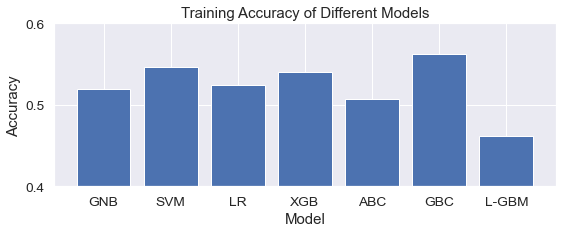

In [80]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']

#Plot of models by accuracy
accuracy = [gnb_cr["accuracy"],
            svm_cr["accuracy"],
            lr_cr["accuracy"],
            xgb_cr["accuracy"],
            abc_cr["accuracy"],
            gbc_cr["accuracy"],
            lightgbm_cr["accuracy"]]
# For after fix
# accuracy =


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Training Accuracy of Different Models')
ax.set_yticks([0.40, 0.5, 0.6])
ax.set_ylim([0.40, 0.6])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [81]:
## Standard Models Test Accuracy##
gnb_vis_pred = y_gnb
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_test)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_test)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

## NN Models ##
# nn_vis_pred = nn_final.predict(X_test)
# vnn_vis_pred = vnn_final.predict(X_test)
# dnn_vis_pred = dnn_final.predict(X_test)
# rnn_vis_pred = rnn_final.predict(X_test)
# gru_vis_pred = gru_final.predict(X_test)
# ltsm_vis_pred = ltsm_final.predict(X_test)
# cnn_vis_pred = cnn_final.predict(X_test)

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

# # Print classification report test
# print(classification_report(y_test, lr_vis_pred))
# print(classification_report(y_test, gnb_vis_pred))
# print(classification_report(y_test, svm_vis_pred))
# print(classification_report(y_test, xgb_vis_pred))
# print(classification_report(y_test, abc_vis_pred))
# print(classification_report(y_test, gbc_vis_pred))
# print(classification_report(y_test, lightgbm_vis_pred))

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)

print(lr_cr["accuracy"])

0.5131578947368421


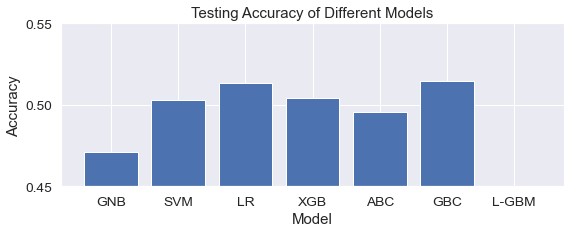

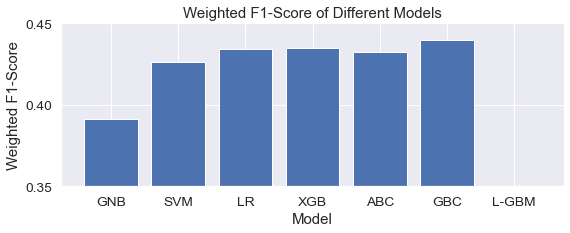

In [82]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']

#Plot of models by accuracy
accuracy = [gnb_cr["accuracy"],
            svm_cr["accuracy"],
            lr_cr["accuracy"],
            xgb_cr["accuracy"],
            abc_cr["accuracy"],
            gbc_cr["accuracy"],
            lightgbm_cr["accuracy"]]
# For after fix
# accuracy =


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Testing Accuracy of Different Models')
ax.set_yticks([0.45, 0.5, 0.55])
ax.set_ylim([0.45, 0.55])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()

#Plot of models by weighted avg f1 score
accuracy = [gnb_cr["weighted avg"]["f1-score"],
            svm_cr["weighted avg"]["f1-score"],
            lr_cr["weighted avg"]["f1-score"],
            xgb_cr["weighted avg"]["f1-score"],
            abc_cr["weighted avg"]["f1-score"],
            gbc_cr["weighted avg"]["f1-score"],
            lightgbm_cr["weighted avg"]["f1-score"]]
# For after fix
# accuracy =


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Weighted F1-Score of Different Models')
ax.set_yticks([0.35, 0.4, 0.45])
ax.set_ylim([0.35, 0.45])
ax.set_xlabel('Model')
ax.set_ylabel('Weighted F1-Score')
plt.show()

In [83]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_train)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_train)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_train)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred = lightgbm_final.predict(X_train)

#Save results as dict
lr_cr = classification_report(y_train, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_train, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_train, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_train, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_train, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_train, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_train, lightgbm_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

# #Collective NN Training Accuracy 
# boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
# boost_cr = boost_cr/4
# print(boost_cr)

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2864 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    1.5s finished


0.5297619047619048
0.5175438596491229


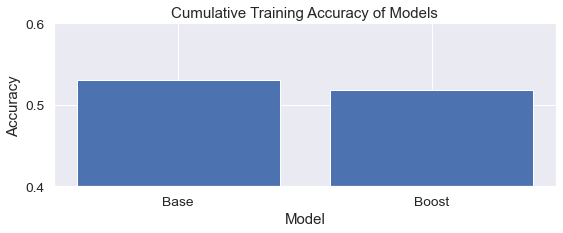

In [84]:
#Names of models for columns
models = ['Base','Boost']
# For after fix
#models = ['Base','Boost','NN']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Training Accuracy of Models')
ax.set_yticks([0.40, 0.5, 0.60])
ax.set_ylim([0.40, 0.60])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [85]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_test)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_test)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_test)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

# #Collective NN Training Accuracy 
# boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
# boost_cr = boost_cr/4
# print(boost_cr)

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2864 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    1.4s finished


0.49561403508771934
0.4784356725146199


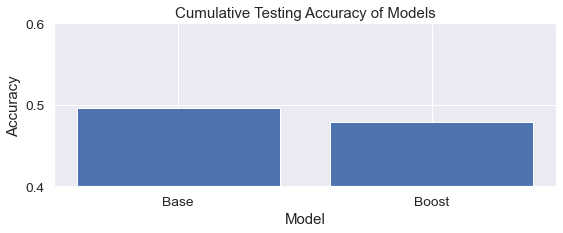

In [86]:
#Names of models for columns
models = ['Base','Boost']
# For after fix
#models = ['Base','Boost','NN']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Testing Accuracy of Models')
ax.set_yticks([0.40, 0.5, 0.60])
ax.set_ylim([0.40, 0.60])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


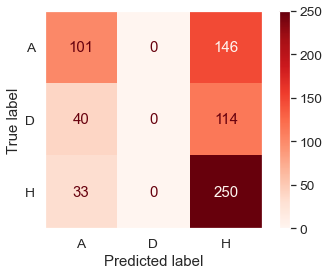

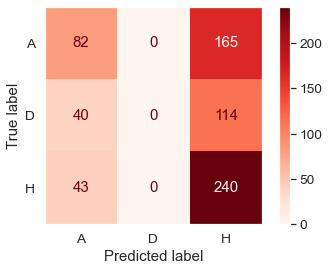

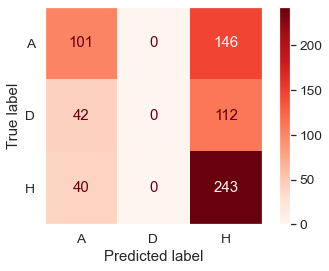

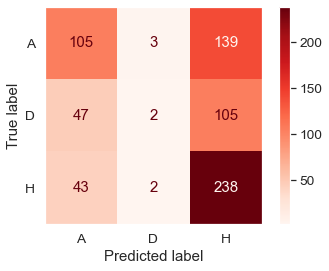

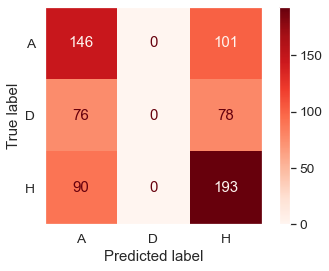

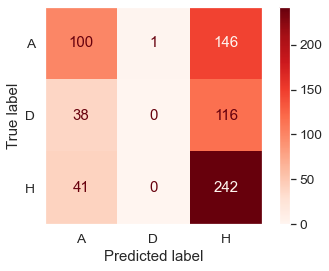

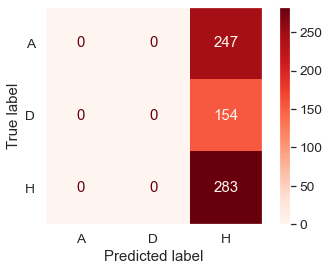

In [78]:
#PLot confusion matrix of all models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_plt (model):
    cm = confusion_matrix(y_test, model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A','D','H'])
    disp.plot(cmap='Reds');
    plt.grid(False)
    plt.show()

confusion_plt(lr_vis_pred)
confusion_plt(gnb_vis_pred)
confusion_plt(svm_vis_pred)
confusion_plt(xgb_vis_pred)
confusion_plt(abc_vis_pred)
confusion_plt(gbc_vis_pred)
confusion_plt(lightgbm_vis_pred)

## 7. Final Predictions on Test Set
<a name='section7'></a>